# Data Cleansing

This dataset, scraped from eBay, contains information on laptops and netbooks, including product titles, descriptions, prices, and seller details. The goal is to clean, standardize, and prepare the data for analysis by handling missing values, duplicates, and formatting inconsistencies. This will enable accurate analysis, such as price trends, brand distribution, and feature comparisons.

## Importing Libraries

We will use the Polars library for data cleaning. Polars is a fast, memory-efficient DataFrame library written in Rust, optimized for large datasets. It provides efficient operations for filtering, grouping, joining, and transforming data.

Polars supports both eager and lazy execution modes for flexibility.

Key tasks will include loading and transforming data, cleaning columns with custom logic, performing aggregations, and handling null values.

In [7]:
# Libraries
import re
from typing import Optional, Tuple, Callable, Any, Reversible

import pandas as pd
import polars as pl
from polars import LazyFrame

# Constants
DATA_SOURCE_PATH = '../data/raw/ebay_laptops_and_netbooks.csv'
DATA_OUTPUT_LOCATION_PATH = '../data/processed/ebay_laptops_and_netbooks_cleansed.parquet'

## Data Exploration

In [8]:
# Loading the dataset
df = pl.read_csv(DATA_SOURCE_PATH)

# Top 10 rows from the dataframe
df.head(n=10)

Brand,Price,Rating,Ratings Count,Condition,Seller Note,Processor,Screen Size,Manufacturer Color,Color,Ram Size,SSD Capacity,GPU,Processor Speed,Type,Release Year,Maximum Resolution,Model,OS,Features,Hard Drive Capacity,Country Region Of Manufacturer,Storage Type
str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""CHUWI""","""$303.68 """,null,null,"""New: A brand-new, unused, unop…",null,"""Quad Core""","""14 in""",null,"""Gray""","""8 GB""","""1 Used, 1 support Max 1TB M.2…","""Intel Iris Plus Graphics 655""","""Max up to 3.80 GHz""","""Notebook/Laptop""","""2021""","""2160 x 1440""","""CoreBook X""","""Windows 11 Home""","""Backlit Keyboard, Built-in Mi…","""512 GB SSD""","""China""","""SSD (Solid State Drive)"""
"""Dell""","""$399.99 to $634.99""",null,null,"""Very Good - RefurbishedThe ite…","""“AAA PCs is a Microsoft Author…","""Intel Core i7 8th Gen.""","""14 in""",null,"""Black""",null,null,"""Intel UHD Graphics 620""","""4.20 GHz (1.90 GHz Base Freque…","""Notebook/Laptop""","""Refurbished in 2023""","""1920 x 1080""","""Dell Latitude 7490""","""Windows 11 Pro""","""Backlit Keyboard, Bluetooth, B…","""2 TB""",null,"""SSD (Solid State Drive)"""
"""Dell""","""$175.00 """,null,null,"""UsedAn item that has been used…","""“Well kept, fully functional, …","""Intel Core i5-6300U""","""14 in""",null,"""Black""","""16 GB""","""500 GB""","""Intel HD Graphics""","""2.40 GHz""","""Notebook/Laptop""","""2019""","""1920 x 1080""","""Dell Latitude E5470""","""Windows 10 Pro""","""10/100 LAN Card, Backlit Keybo…","""500 GB""","""China""","""SSD (Solid State Drive)"""
"""HP""","""$84.99 """,null,null,"""Good - RefurbishedThe item sho…","""“1-Year Allstate warranty. The…","""Intel Celeron N""","""11.6 in""",null,"""Black""","""4 GB""",null,"""Intel HD Graphics 500""","""2.40 GHz""","""Notebook/Laptop""",null,"""1366 x 768""","""HP Chromebook 11 G6""","""Chrome OS""","""Bluetooth, Built-in Microphone…","""16 GB""",null,"""eMMC"""
"""Dell""","""$101.22 """,null,null,"""Good - RefurbishedThe item sho…","""“Laptops is tested & fully wor…","""Intel Core i5 6th Gen.""","""Minimum 12.5""""",null,null,"""8 GB""","""256 GB""","""Integrated""","""Minimum 1.40 GHz""","""Notebook/Laptop""","""2015""","""1366 x 768""","""Various Models""","""Windows 10""","""10/100 LAN Card, Built-in Micr…","""NO HDD""",null,"""SSD (Solid State Drive)"""
"""Acer""","""$49.99 ""","""4.5 out of 5 stars""",193,null,null,"""Intel Celeron""","""11.6 in""","""Black""","""Black""","""4 GB""","""16 GB""",null,"""1.60 GHz""","""Laptop""","""2017""","""1366 x 768""","""Chromebook C738T-C44Z""","""Chrome OS""","""Touchscreen, Bluetooth""",null,null,"""SSD (Solid State Drive)"""
"""HP""","""$39.59 ""","""4.5 out of 5 stars""",23,null,null,"""Intel Celeron""","""11.6 in""",null,"""Black""","""4 GB""","""16GB""",null,"""1.60 GHz""","""Notebook/Laptop""","""2017""",null,"""HP Chromebook 11 G5""","""Chrome OS""","""Bluetooth, Built-in Webcam""","""16 GB""",null,"""SSD (Solid State Drive)"""
"""Acer""","""$34.99 ""","""5 out of 5 stars""",20,null,null,"""Intel Celeron Dual-Core""","""11.6 inin""",null,"""Gray, Granite Gray""","""2GB""",null,null,"""1.00 GHz.4ghz""","""Netbook""",null,null,"""Chromebook C720-2848""","""Chrome OS""",null,"""16GB""",null,null
"""Dell""","""$279.99 """,null,null,"""Excellent - Refurbished: The i…",null,"""i7 7th""","""14 in""",null,"""Black""","""16 GB""","""500 GB""",null,"""2.80 GHz""","""Notebook/Laptop""",null,"""1920 x 1080""","""Dell Latitude 7480""","""win 11 pro""","""Wi-Fi""","""512 GB""",null,"""SSD (Solid State Drive)"""


Observations:

- The Price column contains both price and currency, with some entries in range format (e.g., "$399.99 to $634.99") that need processing before conversion to a numerical variable.
- Some columns, including Price, are treated as strings but should be numeric.
- Several columns have missing values, which need to be addressed during preprocessing.

## Summary Statistics

We compute the summary statistics for our dataset, but we instantly notice most of our columns are nullable, which makes statistics, such as the mean and standard deviation, to output null too.

In [9]:
# Summary statistics
df.describe()

statistic,Brand,Price,Rating,Ratings Count,Condition,Seller Note,Processor,Screen Size,Manufacturer Color,Color,Ram Size,SSD Capacity,GPU,Processor Speed,Type,Release Year,Maximum Resolution,Model,OS,Features,Hard Drive Capacity,Country Region Of Manufacturer,Storage Type
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""count""","""4024""","""6620""","""286""",286.0,"""6004""","""1442""","""3837""","""3890""","""185""","""2149""","""2112""","""2780""","""3088""","""2669""","""3289""","""787""","""2480""","""3148""","""3040""","""2505""","""2332""","""203""","""2388"""
"""null_count""","""2596""","""0""","""6334""",6334.0,"""616""","""5178""","""2783""","""2730""","""6435""","""4471""","""4508""","""3840""","""3532""","""3951""","""3331""","""5833""","""4140""","""3472""","""3580""","""4115""","""4288""","""6417""","""4232"""
"""mean""",null,null,null,42.479021,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""std""",null,null,null,201.257428,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""min""","""?""","""$1,002.67 ""","""1 out of 5 stars""",1.0,"""Certified - Refurbished: The i…","""“""Excellent Condition Touch Sc…","""10th Gen Intel Core i5""","""10 in""","""3000""","""Abyss Blue""","""1 GB""",""".""",""".""","""1.00 GHz""","""2 IN 1 CHROMEBOOK""","""0""","""1024 x 480""","""100e Chromebook""","""ANDROID""",""".""",""".""","""Australia""","""."""
"""25%""",null,null,null,2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,20.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""max""","""xnote""","""$999.95 ""","""5 out of 5 stars""",1533.0,"""Very Good - RefurbishedThe ite…","""“✅ Refurbished ✅ inkl. 19% MwS…","""unknown""","""none""","""onyx black""","""see pictures""","""up to 32GBGB DDR4""","""up to 1TB SSD""","""‎PowerVR GX6250""","""up to 3.6Ghz""","""Écran numériseur""","""see manufacturer""","""See Title/Description""","""xnote""","""‎Windows 11 Home""","""dvd""","""up to 1 TB""","""Unknown""","""ssd"""


## Null Count and Null Proportion

Now, we take a look at the null count and null proportion per each dataframe column:

## Data Types
We look at each column data type in the data frame

In [10]:
# Data Types
pl.DataFrame(data={
    'column': df.columns,
    'dtype': df.dtypes
})

column,dtype
str,object
"""Brand""",String
"""Price""",String
"""Rating""",String
"""Ratings Count""",Int64
"""Condition""",String
…,…
"""OS""",String
"""Features""",String
"""Hard Drive Capacity""",String


## Data Preparation

### Column Renaming

We kick things off by reformatting the column names: lowercasing and removing spaces for underscores. These convention for string data will be STANDARD during our data cleansing process, so that most categorical data is transformed into similar formatting.

In [11]:
# Renaming columns: replacing blank spaces for underscores and lowercasing columns
df = df.rename({col: col.strip().lower().replace(' ', '_') for col in df.columns})
print(df.columns)

['brand', 'price', 'rating', 'ratings_count', 'condition', 'seller_note', 'processor', 'screen_size', 'manufacturer_color', 'color', 'ram_size', 'ssd_capacity', 'gpu', 'processor_speed', 'type', 'release_year', 'maximum_resolution', 'model', 'os', 'features', 'hard_drive_capacity', 'country_region_of_manufacturer', 'storage_type']


### Removing Duplicates

Removing duplicates early keeps the data unique and prevents distorted results. Duplicates, often from multiple listings of the same laptop, can affect price trends and brand distribution. Cleaning them up first ensures more accurate analysis.

In [12]:
print(f'Total rows before removing duplicates: {df.height}')
df = df.unique()
print(f'Total rows after removing duplicates {df.height}')

Total rows before removing duplicates: 6620
Total rows after removing duplicates 4475


### Utility Functions

In [13]:
def value_counts_with_proportion(series: pl.Series,
                                 proportion_col_alias: str = 'proportion',
                                 sort: bool = True,
                                 parallel: bool = True,
                                 decimals: int = 2,
                                 convert_to_pandas: bool = False) -> pl.DataFrame | pd.DataFrame:
    """
    Compute value counts and their proportions for a Polars Series.

    Args:
        series (pl.Series): Input Polars Series.
        proportion_col_alias (str, optional): Name for the proportion column. Defaults to 'proportion'.
        sort (bool, optional): Whether to sort results by count. Defaults to True.
        parallel (bool, optional): Whether to use parallel processing. Defaults to True.
        decimals (int, optional): Number of decimal places for proportions. Defaults to 2.
        convert_to_pandas (bool, optional): If True, return a Pandas DataFrame. Defaults to False.

    Returns:
        pl.DataFrame or pd.DataFrame: DataFrame with unique values, counts, and proportions.
    """
    total_count = series.len()

    result = series.value_counts(sort=sort, parallel=parallel).with_columns(
        (pl.col('count') / total_count).round(decimals).alias(proportion_col_alias)
    )

    return result.to_pandas() if convert_to_pandas else result

In [14]:
def print_series(series: pl.Series, n: int = 10, unique: bool = False) -> None:
    """
    Print summary information and display the first `n` rows of a Polars Series.

    Args:
        series (pl.Series): The Polars Series to print and display.
        n (int, optional): The number of rows to display from the beginning of the Series. Defaults to 10.
        unique (bool, optional): Whether to display only unique values in the Series before selecting the first `n` rows. Defaults to False.

    Returns:
        None
    """
    print(f'Series Shape: {series.shape}')
    print(f'Series Type: {series.dtype}')

    final_series = series.unique() if unique else series

    display(final_series.head(n=n))

## Cleaning `brand`
- **Top categories**: The top three brands—Dell (19%), Lenovo (11%), and HP (7%)—represent a combined 37% of the total brands in the dataset. The null values account for 39% of the data, with 2596 entries marked as null. This is quite a large portion of the dataset. The top 4 categories (`null`, `Dell`, `Lenovo` & `HP`) account for 76% of the dataset.
- **Unknown values**: There's an abundance of brands with very low frequencies, or unknown values (like `?` or `Does not apply`).
- **Inconsistent formatting**: Some entries like `Dell Inc` are not captured under the main brand `Dell` due to inconsistent formatting. Similar things occur to other top brands.
- **Multibrand categories**: Some entries represent several brands, like `Dell / HP / Lenovo` or `Apple / LG`

In [15]:
# Taking a look at the frequency of each brand: total count and proportion
value_counts_with_proportion(df['brand'])

brand,count,proportion
str,u32,f64
null,1333,0.3
"""Dell""",1009,0.23
"""Lenovo""",564,0.13
"""HP""",392,0.09
"""Acer""",117,0.03
…,…,…
"""LiteON""",1,0.0
"""GERICOM""",1,0.0
"""GoldBook""",1,0.0


### **Reformatting `brand`:**

In this step of our analysis, we're focusing on cleaning up and standardizing the `brand` data to ensure consistency and accuracy. Brands can be listed in many different ways, which can lead to confusion or misinterpretation during analysis. So, we're transforming the brand names into a uniform format that makes it easier to work with.

- **Consistent Formatting:** We ensure all brand names are in lowercase, and we remove any unnecessary spaces or punctuation that could create inconsistencies. (transforming `Dell Inc` into `dell_inc`).
- **Replacing Uncertain Values:** We also handle special cases where the data might have uncertain or irrelevant values (e.g., a "?" for unknown brands), replacing them with more meaningful terms like "unbranded" or "unknown."


In [16]:
# Define a mapping to replace certain placeholder values with more meaningful labels.
brand_replace_map = {
    '?': 'unknown',  # Replace '?' with 'unknown' for unknown brands.
    'does_not_apply': 'unknown',  # Replace 'does_not_apply' with 'unknown' to handle irrelevant data.
}

# Clean and normalize the brand names.
df = df.with_columns(
    pl.col('brand')
    .str.to_lowercase()  # Convert brand names to lowercase to ensure uniformity.
    .str.strip_chars()  # Remove any leading whitespace or special characters.
    .str.strip_chars_end('.')  # Specifically remove any trailing dots at the end of brand names.
    .str.replace_all(' / |\\/', ' or ')  # Replace slashes ("/" or " / ") with ' or ' to standardize multi-brand names.
    .str.replace_all(' ', '_')  # Replace spaces with underscores to ensure no spaces in brand names.
    .replace(brand_replace_map)  # Replace values like '?' or 'does_not_apply' based on the predefined map.
    .fill_null('unknown')  # Fill any missing brand values with 'unknown' to handle missing data.
    .alias('brand_clean')
)


### **Identifying and Mapping Top Brands:**

In this step, we're focusing on identifying the most popular brands in the dataset and ensuring that any variations in the brand names are mapped to the correct top brand.

- **Identifying Top Brands:** We start by filtering out any unknown brand names and then count the occurrences of each brand. From this, we identify the top 5 brands with the highest frequency in the dataset.
- **Pattern Matching:** We create a pattern to search for these top brands in the brand names. If the brand name matches one of the top brands (e.g., includes "dell", "hp", etc.), we recognize it as a valid entry for that brand.
- **Mapping Variations to Top Brands:** We then apply a function to map variations of the brand names (e.g., "dell_epsilon" or "hp_dell") to the main brand names (e.g., "dell" or "hp"). This ensures that similar or ambiguous entries are standardized to the correct top brand.

By applying these steps, we ensure that any variations or inconsistencies in the brand names are correctly mapped to the top brands, improving the consistency and accuracy of our analysis.


In [17]:
top_brands = (
    df.filter(pl.col('brand_clean').ne('unknown'))
    .group_by('brand_clean')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
    .head(10)
    .select('brand_clean')
    .to_series()
)


def fetch_first_matching_brand_from_str(string: str, brand_list: list[str] = None) -> str:
    """
    Extracts the first matching brand from a given string.

    Args:
        string (str): The input string containing the brand.
        brand_list (list): List of top brands to check against.

    Returns:
        str: The first matched brand if found; otherwise, the original string.
    """
    brand_list = brand_list or set(top_brands)

    for brand in brand_list:
        if brand + '_' in string:
            return brand
    return string


In [18]:
# Create a regex pattern to match brand names followed by an underscore (_).
is_a_top_brand_string_pattern = "|".join(re.escape(brand_name) for brand_name in top_brands + '_')

# Apply the brand extraction function to standardize brand names.
df = df.with_columns(
    pl
    # Check if the brand contains any of the top brands and isn't a mixed brand like "dell_or_hp".
    .when(
        pl.col('brand_clean').str.contains(is_a_top_brand_string_pattern) &
        ~pl.col('brand_clean').str.contains('_or_')
    )
    # If the condition is met, map the brand name to its standardized version.
    .then(pl.col('brand_clean').map_elements(fetch_first_matching_brand_from_str, return_dtype=pl.Utf8))
    # Otherwise, keep the original brand name.
    .otherwise(pl.col('brand_clean'))
    # Casting to Polars' categorical data type
    .cast(pl.Categorical)
    # Rename the transformed column as 'brand_clean'.
    .alias('brand_clean')
)

print_series(df['brand_clean'])

Series Shape: (4475,)
Series Type: Categorical(ordering='physical')


brand_clean
cat
"""unknown"""
"""samsung"""
"""dell"""
"""unknown"""
"""hp"""
"""unknown"""
"""dell"""
"""dell"""
"""dell"""


In [19]:
# Taking another look at the frequency of each brand: total count and proportion
value_counts_with_proportion(df['brand_clean'])

brand_clean,count,proportion
cat,u32,f64
"""unknown""",1340,0.3
"""dell""",1030,0.23
"""lenovo""",569,0.13
"""hp""",392,0.09
"""acer""",118,0.03
…,…,…
"""liteon""",1,0.0
"""gericom""",1,0.0
"""goldbook""",1,0.0


Observations:
- **More records assigned to `dell`**: `dell` has more than 15 new records. (from `1009` to `1030`). Likely due to previously fragmented brand variations (e.g., `dell_inc`, `dell_xps`) now being mapped correctly to `dell`.
- **Consistent top brands**: The overall ranking of top brands did not change. The counts for `hp`, `acer`, `lg`, `fujitsu_siemens`, `samsung`, `microsoft`  and `auo` remained stable, indicating that these brands were either already well-represented or had fewer naming inconsistencies.

## Cleaning `price`

- **Multiple info**: By analyzing the `price` variable, we realize it also has information about the currency (via symbols like `$`).
- **Inconsistent format**: The cost of a laptop might be fixed (e.g: `880`) or a range (e.g: `from 500 to 999`)
- **Bad typing**: `price` is currently a categorical (`String`) variable, due to commas, whitespaces and symbols. To use this data effectively for statistical models, we **MUST CONVERT** it into **NUMERICAL**, removing currency symbols and handling text-based variations like ranges.

In [20]:
# Taking a look at the first 5 records from the `price` column, as is
df['price'].head(n=10)

price
str
"""$108.04 """
"""$70.03 """
"""$184.99 """
"""$291.24 """
"""$429.00 to $579.00"""
"""$632.74 """
"""$170.00 """
"""$125.96 """
"""$179.00 """


Observations:
- **Variable format**: Cost of a laptop might be either a range (`$399.99 to $634.99`) or a fixed price (`$399.99 to $634.99`).
- **Wrong typing**: Data is currently of `String` data type, instead of a numerical type, due to the presence of currency symbols and words ('to').

### **Reformatting `price`:**

In this step, we focus on cleaning and standardizing the `price` variable to make it usable for further analysis. Currently, the `price` column contains multiple inconsistencies that need to be addressed.

- **Extracting Currency Symbols:** The dataset contains various currency symbols (such as `$`), which are separated from the numerical values, and assigned to a new variable `currency_clean`.
- **Handling Inconsistent Formats:** Prices appear in different formats, sometimes as a single fixed value (`880`) and other times as a range (`from 500 to 999`). We need to extract the lowest value from these ranges (`min_price_clean`) to ensure uniformity.
- **Ensuring Proper Data Types:** After cleaning, we cast the extracted price values to `Float64`, making them compatible with statistical models and numerical computations.


In [21]:
df = df.with_columns(
    # Extract the currency symbol from the price column
    pl.col('price').str.slice(0, 1)
    .cast(pl.Categorical)  # Casting the currency symbol to categorical
    .alias('currency_clean'),
    # Removing the currency symbol, commas from the price and trimming whitespace
    pl.col('price')
    .str.slice(1)  # Removing the currency symbol
    .str.replace(',', '')  # Removing commas
    .str.split("to")  # Separating the price into min_price and max_price range
    .list.first()  # Obtaining the min_price, the first element of the list
    .str.strip_chars()  # Remove leading and trailing characters
    .cast(pl.Float64)  # Casting the min_price to float
    .alias('min_price_clean')  # Renaming to reflect that it's the min price in case of ranges
)

# Preview the transformed data by displaying the top 5 rows
df.select(
    'price', 'currency_clean', 'min_price_clean'
).head(n=10)

price,currency_clean,min_price_clean
str,cat,f64
"""$108.04 ""","""$""",108.04
"""$70.03 ""","""$""",70.03
"""$184.99 ""","""$""",184.99
"""$291.24 ""","""$""",291.24
"""$429.00 to $579.00""","""$""",429.0
"""$632.74 ""","""$""",632.74
"""$170.00 ""","""$""",170.0
"""$125.96 ""","""$""",125.96
"""$179.00 ""","""$""",179.0


## Cleaning `rating` & `ratings_count`

In [22]:
# Taking a look at the frequency of each rating: total count and proportion
value_counts_with_proportion(df['rating'])

rating,count,proportion
str,u32,f64
null,4255,0.95
"""5 out of 5 stars""",100,0.02
"""4.5 out of 5 stars""",85,0.02
"""4 out of 5 stars""",20,0.0
"""3.5 out of 5 stars""",10,0.0
"""3 out of 5 stars""",2,0.0
"""1 out of 5 stars""",2,0.0
"""2 out of 5 stars""",1,0.0


Observations:
- **Extremely high null proportion**: 96% of entries have missing (`null`) ratings, significantly reducing the available data for analysis. Almost the entire column is composed of `null` values.
- **Strong positive bias**: Ratings are overwhelmingly positive, with **5 out of 5 stars (2%)** and **4.5 out of 5 stars (2%)** making up nearly all non-null values. Only **5 instances** have ratings of **3 stars or lower**, making it difficult to assess dissatisfaction trends.
- **Possible numerical conversion**: The `rating` column is currently a String but can be converted into an `Int` **five_star_scale** variable for analysis.

In [23]:
# Taking a look at the frequency of each rating count: total count and proportion
value_counts_with_proportion(df['ratings_count'])

ratings_count,count,proportion
i64,u32,f64
null,4255,0.95
1,48,0.01
2,34,0.01
3,21,0.0
4,14,0.0
…,…,…
36,1,0.0
117,1,0.0
71,1,0.0


Observations:
- **High Null Proportion**: Similarly to `rating`, 96% of entries lack a `ratings_count`, making it almost impossible to gauge customer engagement.
- **Majority Single Reviews**: Most rated products have **1 to 6 reviews**, suggesting limited user feedback. A few products have significantly higher review counts (e.g., **1,533 reviews**), but these are rare.

### Reformatting `rating`

In this step, we transform the `rating` variable to variable `five_star_scale_rating` ( which, as its name implies, is a numerical variable ranging from 1-5; representing the product rating on a five-star scale) as well as clean its format (replacing spaces / decimal points with underscores) and assign the result to `rating_clean`.

In [24]:
# Define the regex pattern for extracting numeric values (including decimals)
rating_pattern = r'(\d+(\.\d+)?)'  # Match whole numbers and decimal numbers (e.g., 4, 4.5)

# Transforming the rating variable
df = df.with_columns(
    # Cleaning the rating column
    pl.col('rating')
    .str.replace_all(r' ', '_')  # Replace spaces with underscores
    .str.replace_all(r'\.', '_')  # Replace decimal point with underscore for values like 3.5
    .cast(pl.Categorical)  # Casting to a categorical column
    .alias('rating_clean'),
    # Using the rating pattern to match numbers
    pl.when(pl.col('rating').str.contains(rating_pattern))
    # If matched, convert to a numerical variable (e.g., 4, 4.5)
    .then(
        pl.col('rating')
        # Extract the numeric value, including decimals
        .str.extract(rating_pattern)
        # Cast to float to handle half-star ratings
        .cast(pl.Float32)
    )
    # Set null for non-matching or missing values
    .otherwise(pl.lit(None).cast(pl.Float32).shrink_dtype())
    .alias('five_star_scale_rating_clean')
)


Now, we inspect our newly created `rating_clean` & `five_star_scale_rating_clean` variables, and compare them to the original `rating` variable

In [25]:
rating_columns = ('rating', 'rating_clean', 'five_star_scale_rating_clean')

df.select(
    rating_columns
).unique(
    subset=rating_columns,
).sort(
    by='five_star_scale_rating_clean',
    descending=True,
)

rating,rating_clean,five_star_scale_rating_clean
str,cat,f32
null,null,null
"""5 out of 5 stars""","""5_out_of_5_stars""",5.0
"""4.5 out of 5 stars""","""4_5_out_of_5_stars""",4.5
"""4 out of 5 stars""","""4_out_of_5_stars""",4.0
"""3.5 out of 5 stars""","""3_5_out_of_5_stars""",3.5
"""3 out of 5 stars""","""3_out_of_5_stars""",3.0
"""2 out of 5 stars""","""2_out_of_5_stars""",2.0
"""1 out of 5 stars""","""1_out_of_5_stars""",1.0


As evidenced, data was successfully reformatted (and assigned to `rating_clean`) as well as parsed to `Float` (and assigned to`five_star_scale_rating_clean`).

### Shrinking `ratings_count`

The `ratings_count` column is correctly parsed as a numerical variable, but we can shrink it, as its range is very small (from `1` to `1533`), as we can see in the summary statistics below.

In [26]:
# Summary statistics the `ratings_count` variable
df.select(
    'ratings_count'
).describe()

statistic,ratings_count
str,f64
"""count""",220.0
"""null_count""",4255.0
"""mean""",36.613636
"""std""",178.959476
"""min""",1.0
"""25%""",2.0
"""50%""",4.0
"""75%""",16.0
"""max""",1533.0


In [27]:
# Shrinking the datatype for the `ratings_count` column
df = df.with_columns(
    pl.col('ratings_count')
    .shrink_dtype()  # Shrink numeric columns to the minimal required datatype.
    .alias('ratings_count_clean')
)

Now, we can see the result of the shrinkage, which transformed the data type from `Int64` to `Int16`:

In [28]:
ratings_count_columns = ['ratings_count', 'ratings_count_clean']
ratings_count_columns_dtypes = zip(
    [f'{x}_dtype' for x in ratings_count_columns],
    df.select(ratings_count_columns).dtypes,
)

dict(ratings_count_columns_dtypes)

{'ratings_count_dtype': Int64, 'ratings_count_clean_dtype': Int16}

## Cleaning `condition`

By analyzing the `condition` variable, we realize it is composed of two separate items, label and description. It is important to create such columns within the dataset:
- **`condition_label`**: A categorical label which represents the condition of a laptop (e.g: `new`, `used`, `certified_refurbished`)
- **`condition_description`**: A description for the `condition_label` (e.g: `A brand-new, unused, unopened laptop...`)

In [29]:
# Taking a look at the values counts for the `condition` column
value_counts_with_proportion(df['condition'])

condition,count,proportion
str,u32,f64
"""Used: An item that has been us…",1340,0.3
"""New: A brand-new, unused, unop…",961,0.21
"""UsedAn item that has been used…",778,0.17
null,462,0.1
"""Seller refurbished: The item h…",397,0.09
…,…,…
"""Certified - RefurbishedThe ite…",27,0.01
"""Very Good - Refurbished: The i…",27,0.01
"""Open box: An item in excellent…",19,0.0


Observations:
- **Similar categories**: Labels `UsedAn item that has been used previously` and `Used: An item that has been used previously` seem to contain duplicate or nearly identical information but are represented differently. Similar things occur for other labels, such as `For parts or not working`. These discrepancies may need to be cleaned and consolidated into one label.
- **Bad formatting**: A considerable amount of labels show formatting issues (e.g., "UsedAn item...") or seem to be concatenated with additional descriptions. This would require text processing to standardize the condition labels and improve consistency.

In [30]:
# Creating a dictionary which represents the condition labels and descriptions

def fetch_default_condition_replace_map() -> dict[str, str]:
    """
    Retrieves the default mapping of condition labels to their corresponding descriptions.

    This function returns a dictionary where the keys represent the condition labels (e.g., "New", "Used",
    "Certified - Refurbished") and the values are detailed descriptions of those conditions, typically used
    for categorizing product status in e-commerce platforms or inventory systems.

    The conditions cover a range from brand-new items to those intended for parts or not working.

    Returns:
        dict[str, str]: A dictionary containing condition labels as keys and their corresponding descriptions as values.

    Example:
        >>> condition_map = fetch_default_condition_replace_map()
        >>> condition_map['New']
        'A brand-new, unused, unopened, undamaged item in its original packaging...'

    Notes:
        - The returned dictionary includes a variety of common product conditions, such as 'New', 'Open box',
          'Certified - Refurbished', 'Used', and 'For parts or not working'.
        - The descriptions are intended to give a clear understanding of what each condition entails, especially
          for product listings or descriptions.
        - The dictionary is static and predefined, providing a standard set of condition descriptions for use
          across the system.
    """
    return {
        'New': """A brand-new, unused, unopened, undamaged item in its original packaging.
    Packaging should be the same as what is found in a retail store, unless the item is handmade or was packaged by the manufacturer in non-retail packaging, such as an unprinted box or plastic bag.""",

        'Open box': """An item in excellent, new condition with no wear.
    The item may be missing the original packaging or protective wrapping, or may be in the original packaging but not sealed.
    The item includes original accessories and may be a factory second.""",

        'Certified - Refurbished': """The item is in pristine, like-new condition.
    It has been professionally inspected, cleaned, and refurbished by the manufacturer or a manufacturer-approved vendor to meet manufacturer specifications.
    The item will be in new packaging with original or new accessories.""",

        'Excellent - Refurbished': """The item is in like-new condition, backed by a one-year warranty.
    It has been professionally refurbished, inspected, and cleaned to excellent condition by qualified sellers.
    The item includes original or new accessories and will come in new generic packaging.""",

        'Very Good - Refurbished': """The item shows minimal wear and is backed by a one-year warranty.
    It is fully functional and has been professionally refurbished, inspected, and cleaned to very good condition by qualified sellers.
    The item includes original or new accessories and will come in new generic packaging.""",

        'Good - Refurbished': """The item shows moderate wear and is backed by a one-year warranty.
    It is fully functional and has been professionally refurbished, inspected, and cleaned to good condition by qualified sellers.
    The item includes original or new accessories and will come in a new generic packaging.""",

        'Seller refurbished': """The item has been restored to working order by the eBay seller or a third party.
    This means the item was inspected, cleaned, and repaired to full working order and is in excellent condition.
    This item may or may not be in original packaging.""",

        'Used': """An item that has been used previously.
    The item may have some signs of cosmetic wear but is fully operational and functions as intended.
    This item may be a floor model or store return that has been used.""",

        'For parts or not working': """An item that does not function as intended and is not fully operational.
    This includes items that are defective in ways that render them difficult to use, items that require service or repair, or items missing essential components.""",

        'No label': 'No description',
    }

In [31]:
# Creating a function to map condition values to a condition dictionary, which represents labels (e.g: `New`) as keys and description as values (e.g: `A brand-new, unused item...`).
def map_condition(value: str, condition_dict: dict[str, str] = None) -> tuple[str, str]:
    """
    Maps a given condition string to a predefined label and its corresponding description.

    Args:
        value (str): The condition value to be matched.
        condition_dict (dict, optional): A dictionary where keys are condition labels and
                                         values are descriptions. Defaults to `condition_replace_map`.

    Returns:
        tuple: A tuple containing the matched label (str) and its corresponding description (str).
               If no match is found, returns ('No label', 'No description').

    Example:
        >>> map_condition("Excellent - Refurbished device")
        ('Excellent - Refurbished', 'The item is in like-new condition, backed by a one-year warranty. ...')

        >>> map_condition("Unknown condition")
        ('No label', 'No description')
    """
    if condition_dict is None:
        condition_dict = fetch_default_condition_replace_map()

    if isinstance(value, str):
        for label, description in condition_dict.items():
            if label in value:
                return label, description
    return 'No label', 'No description'


### Separating condition label and condition description

- **Splitting data**: We assign values from the `condition` column (like `New`, `Used`, or `Refurbished`) to a standardized label and description. This ensures that any variation in wording across the data is unified, so we can easily categorize and compare items.
  - For example, if we have a condition like `Excellent - Refurbished`, it gets split into two parts: a **label** (`Excellent - Refurbished`) and a **description** that explains the condition in more detail (e.g: The item is in like-new condition, backed by a one-year warranty...).
- **Mapping conditions**: Repeated labels with different formats, such as `UsedAn item that has been used previously` and `Used: An item that has been used previously` are mapped to a single `condition_label` (`'Used'`) which helps us achieve a better label representation by getting rid of different categories that represent the same status (`Used`, `New`, etc.).


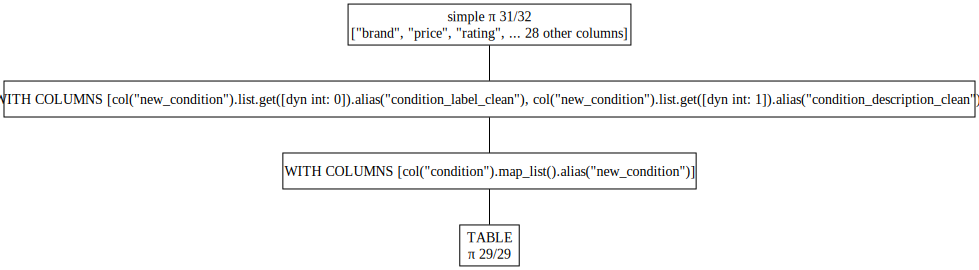

In [32]:
# Transforming the dataframe, creating the `condition_label` and `condition_description` variables
df_lazy_conditions = df.lazy().with_columns(
    pl.col('condition')
    # Applying the `map_condition` function, which maps a string to a predefined label and its corresponding description
    .map_elements(
        function=map_condition,
        skip_nulls=False,
        return_dtype=pl.List(pl.Utf8)
    ).alias('new_condition')  # Creating a temporary column to store results
).with_columns(
    pl.col('new_condition').list.get(0).alias('condition_label_clean'),  # Extract label
    pl.col('new_condition').list.get(1).alias('condition_description_clean')  # Extract description
).drop('new_condition')  # Dropping the temporary column

# Visualize the query plan for the transformation
LazyFrame.show_graph(df_lazy_conditions)

Here we take a look at the values from our `condition` column, and their correspondent **condition labels** and **condition descriptions**.

In [33]:
# Selecting all unique values for condition, and their soon-to-be assigned condition labels and condition descriptions
df_lazy_conditions.unique(
    subset='condition',
    maintain_order=True,
).sort(
    by='condition',
    descending=False,
).select(
    'condition', 'condition_label_clean', 'condition_description_clean'
).collect().to_pandas()

,condition,condition_label_clean,condition_description_clean
0,None,No label,No description
1,Certified - Refurbished: The item is in pristi...,Certified - Refurbished,"The item is in pristine, like-new condition.\n..."
2,Certified - RefurbishedThe item is in pristine...,Certified - Refurbished,"The item is in pristine, like-new condition.\n..."
3,Excellent - Refurbished: The item is in like-n...,Excellent - Refurbished,"The item is in like-new condition, backed by a..."
4,Excellent - RefurbishedThe item is in like-new...,Excellent - Refurbished,"The item is in like-new condition, backed by a..."
5,For parts or not working: An item that does no...,For parts or not working,An item that does not function as intended and...
6,For parts or not workingAn item that does not ...,For parts or not working,An item that does not function as intended and...
7,Good - Refurbished: The item shows moderate we...,Good - Refurbished,The item shows moderate wear and is backed by ...
8,Good - RefurbishedThe item shows moderate wear...,Good - Refurbished,The item shows moderate wear and is backed by ...
9,"New: A brand-new, unused, unopened, undamaged ...",New,"A brand-new, unused, unopened, undamaged item ..."


### **Reformatting `condition`:**

After splitting our `condition` column into `condition_label` and `condition_description`, we will further clean the `condition_label` column by doing the following string operations:
- **Lowercasing:** Modifying all strings to their lowercase equivalent.
- **Standardizing format:** Replacing occurrences hyphens and whitespaces with an underscore (`_`), making the labels more consistent and clean.


In [34]:
def list_reversed(values: Reversible) -> list:
    """
    Reverses the order of the elements in a reversible iterable and returns a list.

    Args:
        values (Reversible): A reversible iterable (e.g., list, tuple, dict_keys) to be reversed.

    Returns:
        list: A list containing the elements of the iterable in reversed order.

    Example:
        >>> list_reversed([1, 2, 3])
        [3, 2, 1]

        >>> list_reversed('abc')
        ['c', 'b', 'a']
    """
    return list(reversed(values))

In [35]:
condition_labels = [x.lower().replace(' - ', '_').replace(' ', '_') for x in fetch_default_condition_replace_map().keys()]
condition_descriptions = fetch_default_condition_replace_map().values()

# Reformatting `condition_label_clean` and `condition_description_clean`: replacing blank spaces for underscores and lowercasing
df = df_lazy_conditions.with_columns(
    pl.col('condition_label_clean')
    .str.to_lowercase()  # Converting the text to lowercase
    .str.replace_all(' - ', '_')  # Replacing hyphen and spaces between words with underscores
    .str.replace_all(' ', '_')  # Replacing spaces with underscores
    .cast(pl.Enum(list_reversed(condition_labels))) # Casting to enum data type
    .alias('condition_label_clean'),
    pl.col('condition_description_clean')
    .cast(pl.Enum(list_reversed(condition_descriptions))) # Casting to enum data type
).collect()  # Materializing the LazyFrame into a DataFrame

# Selecting all unique values for condition, and their respective reformatted condition labels (condition description is not modified, so it is omitted from this lookup)
df.unique(
    subset='condition',
    maintain_order=True,
).sort(
    by='condition',
    descending=False,
).select(
    ['condition', 'condition_label_clean']
)


condition,condition_label_clean
str,enum
null,"""no_label"""
"""Certified - Refurbished: The i…","""certified_refurbished"""
"""Certified - RefurbishedThe ite…","""certified_refurbished"""
"""Excellent - Refurbished: The i…","""excellent_refurbished"""
"""Excellent - RefurbishedThe ite…","""excellent_refurbished"""
…,…
"""Seller refurbishedThe item has…","""seller_refurbished"""
"""Used: An item that has been us…","""used"""
"""UsedAn item that has been used…","""used"""


Finally, we take a look at the new `condition_label` variable and its value counts:

In [36]:
# Taking a look at the values counts for the `condition_label_clean` column
value_counts_with_proportion(df['condition_label_clean'])

condition_label_clean,count,proportion
enum,u32,f64
"""used""",2118,0.47
"""new""",961,0.21
"""no_label""",462,0.1
"""seller_refurbished""",399,0.09
"""for_parts_or_not_working""",122,0.03
"""very_good_refurbished""",119,0.03
"""good_refurbished""",105,0.02
"""excellent_refurbished""",84,0.02
"""open_box""",76,0.02


Observations:
- **New label frequencies**: After cleansing, the most common conditions are `used` (42%) and `new` (29%), which account for the majority of the dataset (71%).
- **Lower cardinality**: We have a considerably minor number of unique values within our `condition_label` variable (**just 10 unique values**), than we did with `condition`, due to the proper cleansing of the data.

## Cleaning `seller_note`

In [37]:
value_counts_with_proportion(series=df['seller_note'], convert_to_pandas=True)

,seller_note,count,proportion
0,None,3356,0.75
1,“See Description For Item Grade”,23,0.01
2,“These units are fully functional and have all...,14,0.00
3,“AAA PCs is a Microsoft Authorized Refurbisher...,13,0.00
4,““Tested working. The Unit shows minor cosmeti...,10,0.00
...,...,...,...
802,“FULLY REFURBISHED AND TESTED. COMES WITH WORK...,1,0.00
803,"“The laptop is manufacturer refurbished ""Like ...",1,0.00
804,“Device is 100% fully functional and in Good p...,1,0.00
805,“Used in fair working condition. May have scra...,1,0.00


Observations:
- **High cardinality**: As this variable represents notes written in natural language, by the seller, specifying any kind of details, each note is unique.
- **Feature engineering potential**: It might be of interest to do sentiment analysis in order to categorize this variable given its sentiment.

In [38]:
df = df.with_columns(
    pl.col('seller_note')
    .str.strip_chars()
    .alias('seller_note_clean')
)

df.select(
    'seller_note_clean'
).head(n=10)

seller_note_clean
str
null
null
null
null
null
null
"""“Laptop is in excellent condit…"
"""“The item will show some signs…"
"""“Includes Dell AC Adapter/Char…"


We decide to leave the `seller_note` column with minimal alteration, simply trimming leading and trailing characters, as it is a variable that contains free-text, natural language information, making it inherently non-standardizable. It is filled with subjective, context-dependent, and unstructured data. This is why it is not easily standardize without potentially losing valuable information.

Nonetheless, proper use of natural language processing (particularly sentiment analysis) would be useful in order to extract consistent insights from such data.


## Cleaning `processor`
- **Formatting**: Similarly, as done with other variables, we'll reformat the values, so that `Intel Celeron` is transformed into `intel_celeron`.
- **Unknown values**: There's an abundance of brands with very low frequencies, or unknown values (like `?` or `Does not apply` or `no` or `none`).


In [39]:
# Taking a look at the values counts for the `processor` column
value_counts_with_proportion(df['processor'])

processor,count,proportion
str,u32,f64
null,1470,0.33
"""Does not apply""",371,0.08
"""Intel Core i5 4th generation""",249,0.06
"""Intel Core i5 6th generation""",161,0.04
"""Intel Celeron""",147,0.03
…,…,…
"""Qualcomm Snapdragon 8cx Gen 3 …",1,0.0
"""intel N100""",1,0.0
"""Intel Core i7 10th generation""",1,0.0


Observations:
- **Missing data**: 42% of the entries are marked as `null` and 8% as `Does not apply`, together representing 50% of the dataset.
- **Low variety**: All processors in the top 10 are of `Intel` brand, with diversity in performance levels but very little in manufacturer.
- **High cardinality**: `processor` contains 462 unique values, as some of its information contains details such as brand (`intel`/`amd`), model (`celeron`), generation (`8th gen`), etc.
- **Feature engineering potential**: Some processors indicate both the model and the generation (`Intel core i5 8th gen`), which can be extracted for further analysis.

### **Reformatting `processor`:**

In this step of our analysis, we're focusing on cleaning up and standardizing the `brand` data to ensure consistency and accuracy. Brands can be listed in many different ways, which can lead to confusion or misinterpretation during analysis. So, we're transforming the brand names into a uniform format that makes it easier to work with.

- **Consistent Formatting:** We ensure all processor names are in lowercase, and we remove any unnecessary spaces or punctuation that could create inconsistencies. (transforming `Intel core - 7th gen.` into `intel_core_7th_gen`).
- **Replacing Uncertain Values:** We also handle special cases where the data might have uncertain or irrelevant values (e.g., `?` or `no`), replacing them with more meaningful values such as `unknown` or `not_applicable`.

In [40]:
 # Define a mapping to handle various non-standard or missing values in the 'processor' column.
processor_replace_map = {
    '?': 'unknown',
    'none': 'unknown',
    'no': 'unknown',
    '^?': 'unknown',
    'does not apply': 'unknown'
}

# Apply the replacement logic to the 'processor' column to clean and standardize the values.
df = df.with_columns(
    pl.col('processor')
    .str.to_lowercase()  # Convert text to lowercase for consistency.
    .str.strip_chars()  # Remove any leading or trailing whitespace.
    .str.replace_all(r'\s+|-', '_')  # Replace spaces / hyphens with underscores for consistent naming.
    .str.replace(',', '')  # Removing comas
    .str.strip_chars_end('.')  # Remove any trailing dots.
    .replace(processor_replace_map)  # Apply the replacement map to clean non-standard values.
    .cast(pl.Categorical) # Cast to categorical data type
    .alias('processor_clean')
)

df.select(
    'processor', 'processor_clean'
).head(n=10)

processor,processor_clean
str,cat
null,null
"""Does not apply""","""does_not_apply"""
"""Intel Core i5-10310u""","""intel_core_i5_10310u"""
null,null
"""Intel Core i3-1115G4""","""intel_core_i3_1115g4"""
null,null
"""Intel Core i7 8th Gen.""","""intel_core_i7_8th_gen"""
"""Intel Core i5 6th Gen""","""intel_core_i5_6th_gen"""
"""Intel Core i5 5th Gen.""","""intel_core_i5_5th_gen"""


In [41]:
# Taking a look at the poorly formatted `processor` values, with their correspondent values in `processor_clean`
df.select(
    'processor', 'processor_clean',
).filter(
    pl.col('processor').str.to_lowercase().is_in(processor_replace_map)
).unique(
    subset='processor',
    maintain_order=True,
).sort(
    by='processor',
    descending=False,
)

processor,processor_clean
str,cat
"""?""","""unknown"""
"""DOES NOT APPLY""","""does_not_apply"""
"""Does Not Apply""","""does_not_apply"""
"""Does not apply""","""does_not_apply"""
"""NONE""","""unknown"""
"""No""","""unknown"""
"""^?""","""unknown"""
"""none""","""unknown"""


Finally, we inspect visually our newly created `processor_clean` variable:

In [42]:
# Taking a look the new `processor_clean` column and its value counts
value_counts_with_proportion(df['processor_clean'])

processor_clean,count,proportion
cat,u32,f64
null,1470,0.33
"""does_not_apply""",376,0.08
"""intel_core_i5_4th_generation""",249,0.06
"""intel_core_i5_6th_generation""",161,0.04
"""intel_celeron""",147,0.03
…,…,…
"""qualcomm_snapdragon_8cx_gen_3_…",1,0.0
"""intel_n100""",1,0.0
"""intel_core_i7_10th_generation""",1,0.0


## Cleaning `screen_size`

In [43]:
# Screen size value counts and their proportion
value_counts_with_proportion(df['screen_size'], convert_to_pandas=True)

,screen_size,count,proportion
0,None,1434,0.32
1,14 in,557,0.12
2,"14""",476,0.11
3,15.6 in,384,0.09
4,Does not apply,369,0.08
...,...,...,...
154,15 in In.4in.,1,0.00
155,DOES NOT APPLY,1,0.00
156,"12"" LED Touchscreen (Outdoor Viewable)",1,0.00
157,15&quot;,1,0.00


### Extracting inches from `screen_size`

In order to have an accurate processing of `screen_size`, we'll extract the inches from the `screen_size` column and assign them to a numerical variable named `screen_size_inches`.

In this way, we can perform further analysis, visualization and numerical computations on the screen size, ensuring that we no longer have to deal with mixed formats.

In [44]:
# Define the regex pattern to extract numeric values (floating point or integer) from screen_size column
screen_size_pattern = r'(\d+(\.\d+)?)'

df = df.with_columns(
    # Clean the screen_size column by extracting the numeric part (screen size in inches)
    pl.col('screen_size')
    .str.extract(screen_size_pattern)  # Extract the numeric part
    .cast(pl.Float32)  # Convert the extracted value to Float64
    .alias('screen_size_inches_clean')
)

df['screen_size_inches_clean'].head(n=10)

screen_size_inches_clean
f32
null
null
14.0
null
15.6
null
12.5
14.0
15.6


We can now take a look at the summary statistics for the new `screen_size_inches` variable

In [45]:
# Looking at the summary statistics for the `screen_size_inches` variable
df['screen_size_inches_clean'].describe()

statistic,value
str,f64
"""count""",2654.0
"""null_count""",1821.0
"""mean""",14.174133
"""std""",19.210987
"""min""",2.0
"""25%""",13.0
"""50%""",14.0
"""75%""",15.0
"""max""",1000.0


Observations:
- **Wide Distribution**: The `screen_size_inches_clean` column has a mean value of 14.40 inches, with a standard deviation of 24.22 inches, indicating a relatively wide spread in values. 25% of the data is below 13.0 inches, and 75% is below 15.0 inches.
- **Missing Data**: The column contains a significant amount of missing values (`null_count = 3289`). This highlights the need for potential imputation or cleaning strategies to handle missing data effectively.
- **Extreme Outliers**: The minimum value is 2.0 inches, while the maximum reaches up to 1000.0 inches, suggesting some extreme outliers, which could distort any analysis or model using this data. These outliers should be further investigated and possibly removed or transformed, when doing *statistical analysis*.

### Correcting outliers

We're interested in correcting the outliers in the `screen_size_inches` column, as the maximum value is that of a `1000` inches, which makes very little sense. We'll start by visualizing the top values from that column, to see whether we have several outliers or this is just the product of an error in the data extraction process:

In [46]:
df['screen_size_inches_clean'].filter(
    predicate=df['screen_size_inches_clean'].is_not_null()
).sort(
    descending=True,
)

screen_size_inches_clean
f32
1000.0
18.4
18.0
18.0
18.0
…
4.5
4.5
2.0


We immediately realize we have just two values of `1000` inches, which are heavily skewing the data. The rest of the distribution lies between the range of `2-18` inches, which is sensible.
In order to address this, we need to find where these values are originally located. Which is, the `screen_size` column:

In [47]:
df.select('screen_size').filter(pl.col('screen_size').str.contains('1000'))

screen_size
str
"""Jumbo Heuer 1000"""


We come to the immediate realization that `Jumbo Heuer 1000`, the original `screen_size` value, is clearly not a valid screen size.

 It doesn't contain any numeric value that would correspond to a typical screen size in inches (e.g., "15.6", "12.5", etc.). Instead, the word "1000" is part of a non-numeric string, likely from a misformatted entry during the web scraping process, or the scraping of a wrong tag. As a result, extracting 1000 as the screen size would lead to misleading or incorrect analysis of the data, as screen sizes in inches don't reach values like 1000 inches.

Hence, we replace these unreasonable values with `None` to ensure that the data used for analysis remains consistent and meaningful.

In [48]:
# Replace rows where screen_size_inches_clean is equal to a thousand (which is incorrect data)
df = df.with_columns(
    pl.when(pl.col('screen_size_inches_clean').is_in([1000]))  # Handle extreme values
    .then(None)  # Replace with None (we might also consider using a default value, like the mean or median)
    .otherwise(pl.col('screen_size_inches_clean'))
    .alias('screen_size_inches_clean')
)

# Sorting the screen size in inches in descending order
df['screen_size_inches_clean'].filter(
    predicate=df['screen_size_inches_clean'].is_not_null()
).sort(
    descending=True,
)

screen_size_inches_clean
f32
18.4
18.0
18.0
18.0
18.0
…
4.5
4.5
2.0


Now, we see that the maximum value for the *screen size in inches* variable make a lot more sense. We proceed to visualize its summary statistics once again:

In [49]:
# Looking back at the summary statistics for the `screen_size_inches` variable
df['screen_size_inches_clean'].describe()

statistic,value
str,f64
"""count""",2653.0
"""null_count""",1822.0
"""mean""",13.802545
"""std""",1.613322
"""min""",2.0
"""25%""",13.0
"""50%""",14.0
"""75%""",15.0
"""max""",18.4


Observations:
- **Narrower distribution**: The new statistics show a mean of `13.81` inches with a standard deviation of `1.61` inches. This is an **HIGH REDUCTION** in variability, particularly compared to the previous standard deviation of `24.22` inches. This suggests that removing extreme outliers has led to a more consistent and predictable distribution of screen sizes.

## Cleaning `manufacturer_color` & `color`
Manufacturer color consists of the color specified by the laptop manufacturer. By analyzing the value counts in the `manufacturer_color` column, we can visualize that:
- Manufacturer color is almost composed entirely of `NULL` values, with 97% of its values being null.
- Some entries represent multiple colors in a single field (e.g: `Black & Silver`).
- Most entries have very little frequency, appearing a single time in the entire column. These rare values might be considered noise (and grouped into a rare label category, such as `rare` or `other`) or might to be grouped into broader categories by using the color label (such as grouping `Mica Silver` and `Ice Blue` into a broader `Blue` category).

In [50]:
# Color value counts and their proportion
value_counts_with_proportion(df['manufacturer_color'])

manufacturer_color,count,proportion
str,u32,f64
null,4330,0.97
"""Black""",37,0.01
"""Silver""",29,0.01
"""Gray""",8,0.0
"""Natural Silver""",6,0.0
…,…,…
"""Titanium Gray""",1,0.0
"""Peacock Teal""",1,0.0
"""Royal Blue""",1,0.0


Observations:
- **Almost all data is NULL**: The `manufacturer_color` column contains a large amount of missing data, with 6435 instances marked as `null`, representing 97% of the dataset. This makes the variable have very little influence for further analysis or modeling techniques.
- **Diverse color variants**: The column contains various color names with different variations and formats, such as `Black & Silver` and `Matte Black`, as well as entries like `Iron Grey, Ice Blue` and `Scarlet red cover and base, natural silver keyboard frame` which suggest complex multi-color or detailed descriptions. These need to be **STANDARDIZED FOR CONSISTENCY**.
- **Low Frequency Entries**: A significant number of color values appear only once or twice. These rare values might be considered noise or need to be grouped into broader categories to improve the utility of this feature for analysis or modeling.


Similarly, `color` consists of the actual color of the laptop as listed by the seller. By analyzing the value counts in the `color` column, we can visualize that:
- Color is currently a variable with a high number of nulls, which compose approx. 68% of the column.
- Color contains data in spanish, as evidenced by some of its values: `borgoña` (burgundy), `blanco` (white) or `negro` (black).
- Some entries represent multiple colors in a single field (e.g: `Black/ Blue / Sandtone / Platinum`).

In [51]:
# Color value counts and their proportion
value_counts_with_proportion(df['color'])

color,count,proportion
str,u32,f64
null,2816,0.63
"""Black""",792,0.18
"""Silver""",305,0.07
"""Gray""",191,0.04
"""Negro""",158,0.04
…,…,…
"""Gray / Silver""",1,0.0
"""Black/Red""",1,0.0
"""Fog Blue Aluminum""",1,0.0


Observations:
- **Missing Data**: A significant portion of the data is missing, with 68% of instances marked as `null`. This indicates that a large part of the `color` information is unavailable, which may require additional cleaning, maybe imputation strategies, to handle effectively.
- **Different Languages**: The `color` column includes color names in spanish, such as `Negro` (Spanish for black) and `Gris` (Spanish for gray), as well as English terms like `Carbon Black` and `Silver`. This inconsistency in language could lead to confusion in analysis or models, and standardizing the language or grouping similar colors may be beneficial.
- **Multiple Colors**: Some entries, like `Black/ Blue / Sandtone / Platinum` or `Multicolor`, represent multiple colors in a single field. These values may need to be split into individual colors or categorized into a broader "multicolor" group to maintain consistency and facilitate analysis.

### **Reformatting `manufacturer_color`:**
In this step of our analysis, we're focusing on cleaning up and standardizing the `manufacturer_color` data to ensure consistency and accuracy.
- **Reducing cardinality:** The color data may contain variations or inconsistencies in how colors are labeled (e.g., `multi-color` vs. `multicolor`). We address this by grouping similar colors under consistent labels, reducing the number of unique color categories. We also map color variations (e.g, `sky blue`, `light blue`) to a single color (`blue`).
- **Standardizing format:** Check whether the color listed for each item matches a set of predefined valid colors. Ensures that all color data follows a consistent format.

In [52]:
def fetch_valid_colors_list() -> list[str]:
    """
    Retrieves a list of valid color values used for consistency checks.

    This function returns a predefined list of color names in lowercase, representing common colors
    used in product descriptions, inventory management, or other applications requiring color categorization.
    The list ensures that color values are consistent across various data entries and avoids discrepancies
    in color terminology.

    Returns:
        list[str]: A list of valid color values as strings.

    Example:
        >>> valid_colors = fetch_valid_colors_list()
        >>> valid_colors
        ['beige', 'black', 'blue', 'bronze', 'brown', 'burgundy', 'gold', 'gray', 'green', 'grey',
        'orange', 'pink', 'platinum', 'purple', 'red', 'silver', 'teal', 'white', 'yellow']
    """
    return [
        'beige', 'black', 'blue', 'bronze', 'brown', 'burgundy', 'gold', 'gray', 'green', 'grey',
        'orange', 'pink', 'platinum', 'purple', 'red', 'silver', 'teal', 'white', 'yellow'
    ]


def fetch__spanish_to_english_colors_translation() -> dict[str, str]:
    """
    Retrieves the Spanish-to-English translation map for color names.

    This function returns a dictionary where the keys are color names in Spanish and the values
    are their corresponding English color names. The map is useful for translating Spanish color inputs
    into their standard English representations, ensuring consistency and clarity when working with bilingual
    or internationalized data.

    Returns:
        dict[str, str]: A dictionary mapping Spanish color names to their English equivalents.

    Example:
        >>> colors_translation = fetch__spanish_to_english_colors_translation()
        >>> colors_translation['negro']
        'black'
    """
    return {
        'negro': 'black',
        'borgoña': 'burgundy',
        'platino': 'platinum',
        'gris': 'grey',
        'blanco': 'white',
        'plata transparente': 'transparent silver',
    }


def fetch_default_color_replace_map() -> dict[str, str]:
    """
    Retrieves the color replacement map for various shorthand or alternative color representations.

    This function returns a dictionary where keys represent color names in shorthand or variant forms,
    and values represent the standardized color names. The map includes commonly used abbreviations as well
    as Spanish-to-English translations to ensure consistency across different color-related data entries.
    This map is essential for normalizing color inputs and improving data consistency in applications requiring
    standardized color representations.

    Returns:
        dict[str, str]: A dictionary mapping color shorthands or variants to standardized color names.

    Example:
        >>> color_replace_map = fetch_default_color_replace_map()
        >>> color_replace_map['blk']
        'black'
        >>> color_replace_map['multi']
        'multicolor'
    """
    return {
        'multi': 'multicolor',
        'multi-color': 'multicolor',
        'blk': 'black',
        **fetch__spanish_to_english_colors_translation(),
    }


In [53]:
def clean_colors(color: str, valid_colors_list: list[str] = None) -> str:
    """
    Cleans and categorizes the input color string based on a predefined list of valid colors.

    This function processes the input color string (`color`) to determine its category based on matching
    valid color values. It performs the following checks:
    - If the input color string matches multiple valid colors, it returns 'multicolor'.
    - If it matches exactly one valid color, it returns that specific color (e.g., 'red').
    - If no valid colors are found, it returns 'other'.

    The function is useful for standardizing and categorizing color values, especially when handling product descriptions,
    inventory data, or user inputs with potentially varied or unstandardized color names.

    Args:
        color (str): The input color string to be cleaned and categorized. It may include color names in different formats or case.
        valid_colors_list (list[str], optional): A list of valid color values to check against. If not provided, the function uses
                                                  the `valid_color_values` list returned by `fetch_valid_colors_list()`.

    Returns:
        str: The cleaned and categorized color. Possible values are:
             - A valid color name from the `valid_colors_list` (e.g., 'red')
             - 'multicolor' if multiple valid colors are found in the input
             - 'other' if no valid color matches.

    Example:
        >>> clean_colors('Red and black shoes')
        'multicolor'
        >>> clean_colors('Pink', fetch_valid_colors_list())
        'pink'
        >>> clean_colors('Sky Blue')
        'blue'
    """
    if valid_colors_list is None:
        valid_colors_list = fetch_valid_colors_list()

    color_count = sum(1 for c in valid_colors_list if c in color.lower())

    if color_count > 1:
        return 'multicolor'
    elif color_count == 1:
        return next((c for c in valid_colors_list if c in color.lower()), 'other')
    else:
        return 'other'


def get_valid_color_string_pattern() -> str:
    """
    Generates a regular expression pattern to match valid color names.

    This function constructs a regular expression pattern by joining all valid color names
    (fetched from `fetch_valid_colors_list`) using the `|` (OR) operator. The result is a pattern
    that can be used to match any of the valid color names in a string, ensuring that only recognized
    colors are identified.

    The function also escapes special characters in the color names to ensure they are treated as literal
    values in the regular expression.

    Returns:
        str: A regular expression pattern that matches any valid color name.

    Example:
        >>> pattern = get_valid_color_string_pattern()
        >>> pattern
        'beige|black|blue|bronze|brown|burgundy|gold|gray|green|grey|orange|pink|platinum|purple|red|silver|teal|white|yellow'
    """
    return "|".join(re.escape(color) for color in fetch_valid_colors_list())


def clean_colors_with_multicolor_and_rare_encoding(
        colors: pl.Expr,
        color_cleaning_function: Callable[[Any], Any] = clean_colors,
        multicolor_label: str = 'multicolor',
        rare_label: str = 'other',
        valid_color_string_pattern: str = get_valid_color_string_pattern(),
        return_dtype: pl.DataType = pl.Utf8,
) -> pl.Expr:
    """
    Cleans and classifies color values into valid colors, multicolor, or rare categories.

    This function processes a series of color values by first checking if they match a
    valid color pattern. If they do, it applies the provided color cleaning function to
    standardize the color value. If the color is a valid single color, it returns the cleaned color.
    If the color is 'multicolor', it returns the label for multicolor. Any other colors or invalid
    values are classified as 'rare' and assigned a specified rare label.

    Args:
        colors (pl.Expr): A Polars expression representing the series of color values to be processed.
        color_cleaning_function (Callable[[Any], Any], optional): A function to clean or standardize valid color values.
            Defaults to `clean_colors`.
        multicolor_label (str, optional): The label used for multicolor values. Defaults to 'multicolor'.
        rare_label (str, optional): The label used for colors that don't match the valid or multicolor criteria. Defaults to 'other'.
        valid_color_string_pattern (str, optional): A regex pattern used to validate the color strings. Defaults to `get_valid_color_string_pattern()`.
        return_dtype (pl.DataType, optional): The data type to return after the color cleaning. Defaults to `pl.Utf8` (string).

    Returns:
        pl.Expr: A Polars expression with the cleaned and labeled color values, either valid color, multicolor, or rare.

    Example:
        >>> cleaned_colors = clean_colors_with_multicolor_and_rare_encoding(colors)
        >>> cleaned_colors
        <Polars expression with cleaned and labeled colors>
    """
    return pl.coalesce(
        # If color is valid then apply the `clean_color` function, and map its value to a valid color, multicolor or other (rare label, for invalid color categories)
        pl.when(colors.str.contains(valid_color_string_pattern))
        .then(colors.map_elements(color_cleaning_function, return_dtype=return_dtype)),
        # If color value is set to multicolor, then return multicolor
        pl.when(colors.eq(multicolor_label))
        .then(pl.lit(multicolor_label))
        # If value is not multicolor nor a single color,then assign it to `other`
        .otherwise(pl.lit(rare_label))
    )


In [54]:
# Prepare the color column by converting to lowercase and applying the color replacements
manufacturer_color_reformatted = (
    pl.col('manufacturer_color')
    .str.to_lowercase()
    .replace(fetch_default_color_replace_map())
)

df = df.with_columns(
    clean_colors_with_multicolor_and_rare_encoding(colors=manufacturer_color_reformatted)
    .str.replace('grey',
                 'gray')  # Naturally, we need to map grey to gray (or vice versa) as it represents the same color
    .cast(pl.Categorical) # Casting to categorical data type
    .alias('manufacturer_color_clean')
)

# Printing the unique values for our new manufacturer color clean variable.
print_series(df['manufacturer_color_clean'], unique=True)

Series Shape: (4475,)
Series Type: Categorical(ordering='physical')


manufacturer_color_clean
cat
"""other"""
"""black"""
"""silver"""
"""gray"""
"""multicolor"""
"""blue"""
"""teal"""
"""platinum"""


We further inspect the original unique values of the `manufacturer_color` column, and its correspondent mapping in `manufacturer_color_clean`:

In [55]:
# Taking a look at all the transformed color labels
df.select(
    'manufacturer_color', 'manufacturer_color_clean',
).unique(
    subset='manufacturer_color',
    maintain_order=True,
).sort(
    by='manufacturer_color',
).transpose(
    include_header=True,
    header_name='column_name',
)

column_name,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""manufacturer_color""",null,"""3000""","""5000""","""Abyss Blue""","""Arctic Gray""","""Black""","""Black & Silver""","""Brushed Black""","""Carbon Black""","""Dark Teal""","""Deep Black""","""Graphite Black""","""Graphite Gray""","""Gray""","""Gray / Black""","""Grey""","""Ice Blue/Iron Gray""","""Iron Grey""","""Iron Grey, Ice Blue""","""Jet Black""","""Matte Black""","""Mica Silver""","""Mineral Silver""","""Moonstone Grey""","""Natural Silver""","""Neptune Blue""","""Nightfall Black""","""Peacock Teal""","""Performance Blue""","""Phantom Black""","""Phantom Gray""","""Platinum""","""Platinum Gray""","""Platinum Grey""","""Platinum Silver""","""Poseidon Blue""","""Prism Black""","""Pure Silver""","""Royal Blue""","""Sandstone""","""Scarlet red cover and base, na…","""Silver""","""Silver/Grey""","""Sky""","""Space Gray""","""Steel Gray""","""Storm Gray""","""Titanium Gray""","""Yes""","""black""","""onyx black"""
"""manufacturer_color_clean""","""other""","""other""","""other""","""blue""","""gray""","""black""","""multicolor""","""black""","""black""","""teal""","""black""","""black""","""gray""","""gray""","""multicolor""","""gray""","""multicolor""","""gray""","""multicolor""","""black""","""black""","""silver""","""silver""","""gray""","""silver""","""blue""","""black""","""teal""","""blue""","""black""","""gray""","""platinum""","""multicolor""","""multicolor""","""multicolor""","""blue""","""black""","""silver""","""blue""","""other""","""multicolor""","""silver""","""multicolor""","""other""","""gray""","""gray""","""gray""","""gray""","""other""","""black""","""black"""


### **Reformatting `color`:**
We do similarly with `color` as we did with `manufacturer_color` by translating, reducing cardinality and standardizing its format in the following manner:
- **Translating from Spanish to English:** We translate color names from Spanish to English to ensure that all color information is standardized, regardless of the language it was originally provided in.
- **Reducing cardinality:** The color data may contain variations or inconsistencies in how colors are labeled (e.g., `multi-color` vs. `multicolor`). We address this by grouping similar colors under consistent labels, reducing the number of unique color categories. We also map color variations (e.g, `sky blue`, `light blue`) to a single color (`blue`).
- **Standardizing format:** check whether the color listed for each item matches a set of predefined valid colors. Ensures that all color data follows a consistent format.

In [56]:
# Prepare the color column by converting to lowercase and applying the color replacements
color_reformatted = (
    pl.col('color')
    .str.to_lowercase()
    .replace(fetch_default_color_replace_map())
)

df = df.with_columns(
    clean_colors_with_multicolor_and_rare_encoding(colors=color_reformatted)
    .str.replace('grey',
                 'gray')  # Naturally, we need to map grey to gray (or vice versa) as it represents the same color
    .cast(pl.Categorical) # Casting to categorical data type
    .alias('color_clean')
)

print_series(df['color_clean'], unique=True)

Series Shape: (4475,)
Series Type: Categorical(ordering='physical')


color_clean
cat
"""other"""
"""gray"""
"""black"""
"""silver"""
"""multicolor"""
"""blue"""
"""white"""
"""yellow"""
"""teal"""


We further inspect the original unique values of the `color` column, and its correspondent mapping in `color_clean`:

In [57]:
# Taking a look at all the transformed color labels
df.select(
    'color', 'color_clean',
).unique(
    subset='color',
    maintain_order=True,
).sort(
    by='color',
).transpose(
    include_header=True,
    header_name='column_name',
)

column_name,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73,column_74,column_75,column_76,column_77,column_78,column_79,column_80,column_81,column_82
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""color""",null,"""Abyss Blue""","""Arctic Grey""","""BLACK""","""BLK""","""Beige""","""Black""","""Black / Gray""","""Black / Grey""","""Black / Silver""","""Black/ Blue / Sandtone / Plati…","""Black/Blue""","""Black/Gray""","""Black/Red""","""Blanco""","""Blue""","""Bronze""","""Brown""","""Carbon Black""","""Charcoal Gray""","""Cloud Grey""","""Dark Brown""","""Dark Grey""","""Dark Metallic Moon""","""Eclipse Gray""","""Fog Blue Aluminum""","""Gold""","""Gray""","""Gray / Silver""","""Gray and Black""","""Gray, Blue""","""Gray, Granite Gray""","""Gray, Platinum Silver""","""Green""","""Grey""","""Grey/Black""",…,"""Multicolor""","""Natural Silver""","""Negro""","""Orange""","""Pink""","""Plata Transparente""","""Platino""","""Platinum""","""Platinum Silver""","""Pure Silver""","""Purple""","""Quiet Blue""","""Red""","""STEEL GRAY""","""Sandstone""","""See Photos""","""Silver""","""Silver & Black""","""Silver + Black""","""Silver / Black""","""Silver and Black""","""Silver, Black""","""Silver, Metallic Silver""","""Silver, Platinum Silver""","""Silver/Black""","""Space Gray""","""Standard""","""Steam Blue""","""Storm Gray""","""Teal""","""Tech Black""","""Warm Gold""","""White""","""Yellow""","""black""","""borgoña""","""see pictures"""
"""color_clean""","""other""","""blue""","""gray""","""black""","""black""","""beige""","""black""","""multicolor""","""multicolor""","""multicolor""","""multicolor""","""multicolor""","""multicolor""","""multicolor""","""white""","""blue""","""bronze""","""brown""","""black""","""gray""","""gray""","""brown""","""gray""","""other""","""gray""","""blue""","""gold""","""gray""","""multicolor""","""multicolor""","""multicolor""","""gray""","""multicolor""","""green""","""gray""","""multicolor""",…,"""multicolor""","""silver""","""black""","""orange""","""pink""","""silver""","""platinum""","""platinum""","""multicolor""","""silver""","""purple""","""blue""","""red""","""gray""","""other""","""other""","""silver""","""multicolor""","""multicolor""","""multicolor""","""multicolor""","""multicolor""","""silver""","""multicolor""","""multicolor""","""gray""","""other""","""blue""","""gray""","""teal""","""black""","""gold""","""white""","""yellow""","""black""","""burgundy""","""other"""


We can also visualize its new value counts:

In [58]:
# Color cleaned value counts and their proportion
value_counts_with_proportion(df['color_clean'])

color_clean,count,proportion
cat,u32,f64
"""other""",2831,0.63
"""black""",962,0.21
"""silver""",315,0.07
"""gray""",222,0.05
"""blue""",49,0.01
…,…,…
"""orange""",2,0.0
"""beige""",2,0.0
"""yellow""",1,0.0


Observations:
- **Lower cardinality and higher frequencies**: As a consequence of mapping colors into broader color categories and the rare category (`other`) the cardinality has decreased from more than 80 different colors to 20. This has also caused the increase in the proportion of several categories, such as `black` increasing from 15% to 19%.

## Cleaning `ram_size`, `ssd_capacity` & `hard_drive_capacity`

### **Understanding the Variables**
These three variables represent key hardware specifications of a laptop, which are crucial for performance assessment:
- **`ram_size`**: Represents the amount of Random Access Memory (RAM) available in the laptop, typically measured in gigabytes (GB). Higher RAM allows for better multitasking and performance.
- **`ssd_capacity`**: Indicates the storage capacity of the Solid-State Drive (SSD), measured in GB or TB. SSDs provide faster read/write speeds compared to traditional hard drives.
- **`hard_drive_capacity`**: Represents the storage capacity of traditional Hard Disk Drives (HDDs), also measured in GB or TB. HDDs are slower than SSDs but provide larger storage at a lower cost.

### **Observations:**
- **Data Format Variability**: Storage and memory values can be represented in different formats (e.g., `8GB`, `16 GB`, `1 TB`, `256GB SSD`). Standardizing these formats ensures consistency.
- **Mixed Numerical and Text Values**: Some entries include both numerical values and units (`GB`, `TB`), which need to be extracted and converted into a standardized numeric format.
- **NULL or Missing Data**: Some laptops may have missing values for these fields. If a laptop has an `ssd_capacity`, but no `hard_drive_capacity`, it likely has only an SSD and vice versa.
- **Overlapping Storage Types**: Some entries might list both `ssd_capacity` and `hard_drive_capacity`, indicating hybrid storage (both SSD and HDD). We need to ensure such cases are handled properly.
- **Extreme or Unusual Values**: Some listings might contain errors, such as `4GB SSD` (which is likely incorrect). Detecting and handling anomalies is essential.

In [59]:
value_counts_with_proportion(df['ram_size'])

ram_size,count,proportion
str,u32,f64
null,2814,0.63
"""8 GB""",507,0.11
"""16 GB""",457,0.1
"""4 GB""",369,0.08
"""32 GB""",95,0.02
…,…,…
"""Up to 40GB""",1,0.0
"""4 GB DDR4""",1,0.0
"""8 GB DDR4 Installed---Can upgr…",1,0.0


In [60]:
value_counts_with_proportion(df['ssd_capacity'])

ssd_capacity,count,proportion
str,u32,f64
null,2246,0.5
"""256 GB""",418,0.09
"""512 GB""",332,0.07
"""240GB""",268,0.06
"""120GB""",180,0.04
…,…,…
"""476GB""",1,0.0
"""16 GB SSD""",1,0.0
"""No SSD""",1,0.0


In [61]:
value_counts_with_proportion(df['hard_drive_capacity'])

hard_drive_capacity,count,proportion
str,u32,f64
null,2592,0.58
"""NO""",710,0.16
"""256 GB""",226,0.05
"""512 GB""",176,0.04
"""16 GB""",99,0.02
…,…,…
"""800 GB""",1,0.0
"""Non""",1,0.0
"""81GB""",1,0.0


### **Reformatting & Cleaning Process:**
To clean and standardize these variables, we apply the following steps:
- **Extract Numeric Values**: Strip out text (e.g., `GB`, `TB`) and convert values into a numerical format for consistency.
- **Extract Units**: Extract the unit of data being used to measure the size (e.g., `GB`, `TB`, `MB`).

By applying these transformations, we ensure that these key specifications are cleaned, standardized, and usable for further analysis or modeling.



In [62]:
def find_size(split_str: str, unit_match_str: str, unit_name: str) -> Tuple[Optional[float], str]:
    """
    Extracts the numerical value of a given storage capacity from a string.

    Args:
        split_str (str): The cleaned and lowercased capacity string.
        unit_match_str (str): The unit identifier to match (e.g., 'gb', 'tb', 'mb').
        unit_name (str): The readable name of the unit.

    Returns:
        Tuple[Optional[float], str]: A tuple containing:
            - The extracted capacity as a float, or None if parsing fails.
            - The unit name.
    """
    try:
        if unit_match_str in split_str:
            capacity = re.sub('[a-z]', '', split_str[:split_str.find(unit_match_str)])
            return float(capacity), unit_name
        return None, unit_name
    except ValueError:
        return None, unit_name


def clean_size_from_str(capacity: str) -> Tuple[Optional[float], str]:
    """
    Cleans and extracts storage capacity from a raw string.

    Args:
        capacity (str): The raw storage capacity string.

    Returns:
        Tuple[Optional[float], str]: A tuple containing:
            - The extracted storage capacity as a float, or None if it cannot be determined.
            - The detected unit (e.g., 'gigabytes', 'terabytes', 'megabytes', or 'unknown').
    """
    # If capacity is none or a blank string
    if capacity is None or not capacity.strip():
        return None, 'unknown'

    # String for caseless comparisons
    capacity_casefold = capacity.casefold()
    # Splitting the casefolded string
    split_str = ''.join(capacity_casefold.split())

    # Checks for gigabytes
    if 'gb' in split_str:
        return find_size(split_str=split_str, unit_match_str='gb', unit_name='gigabytes')
    # Checks for terabytes
    elif 'tb' in split_str:
        capacity_in_tb = split_str[split_str.find('tb') - 1:split_str.find('tb')]
        return float(capacity_in_tb), 'terabytes'
    # Checks for megabytes
    elif 'mb' in split_str:
        return find_size(split_str=split_str, unit_match_str='mb', unit_name='megabytes')
    # Checks for capacity values without a unit (e.g., '128', '389', or '128 SSD')
    else:
        # Remove alphabetic characters (like 'SSD') from the string
        numeric_str = re.sub(r'[a-zA-Z]', '', split_str)

        # Check if the remaining string is a valid number (integer or float)
        is_numeric = re.match(r'^\d+(\.\d+)?$', numeric_str)

        if is_numeric:
            return float(numeric_str), 'unknown'
    # Unspecified capacity nor unit
    return None, 'unknown'


def extract_capacity_value(capacity: str) -> float:
    """
    Extracts the numerical value of a storage capacity from a given string.

    Args:
        capacity (str): The raw storage capacity string.

    Returns:
        float: The extracted storage capacity as a float, or None if parsing fails.
    """
    return clean_size_from_str(capacity)[0]


def extract_capacity_unit(capacity: str) -> str:
    """
    Extracts the unit of a storage capacity from a given string.

    Args:
        capacity (str): The raw storage capacity string.

    Returns:
        str: The extracted unit ('gigabytes', 'terabytes', 'megabytes', or 'unknown').
    """
    return clean_size_from_str(capacity)[1]


In [63]:
# Extracting the hard drive size (numerical) and its unit
df = df.with_columns(
    pl.col('hard_drive_capacity')
    .str.to_lowercase()
    .map_elements(function=extract_capacity_value, return_dtype=pl.Float64)
    .alias('hard_drive_size_clean'),
    pl.col('hard_drive_capacity')
    .str.to_lowercase()
    .map_elements(function=extract_capacity_unit, return_dtype=pl.String)
    .cast(pl.Enum(['unknown', 'megabytes', 'gigabytes', 'terabytes']))
    .alias('hard_drive_size_unit_clean')
)

df.select(
    'hard_drive_capacity', 'hard_drive_size_clean', 'hard_drive_size_unit_clean'
).unique(
    subset='hard_drive_capacity'
)

hard_drive_capacity,hard_drive_size_clean,hard_drive_size_unit_clean
str,f64,enum
"""Non""",null,"""unknown"""
"""256 GB SSD""",256.0,"""gigabytes"""
"""16GB""",16.0,"""gigabytes"""
"""256 GB 512 GB 1 TB 2 TB""",256.0,"""gigabytes"""
"""512 GB SSD Solid State Drive""",512.0,"""gigabytes"""
…,…,…
"""120 GB""",120.0,"""gigabytes"""
"""800 GB""",800.0,"""gigabytes"""
"""2 TB""",2.0,"""terabytes"""


In [64]:
df = df.with_columns(
    pl.col('ram_size')
    .str.to_lowercase()
    .map_elements(function=extract_capacity_value, return_dtype=pl.Float64)
    .alias('ram_size_clean'),
    pl.col('ram_size')
    .str.to_lowercase()
    .map_elements(function=extract_capacity_unit, return_dtype=pl.String)
    .cast(pl.Enum(['unknown', 'megabytes', 'gigabytes', 'terabytes']))
    .alias('ram_size_unit_clean')
)

df.select(
    'ram_size', 'ram_size_clean', 'ram_size_unit_clean'
).unique(
    subset='ram_size'
)

ram_size,ram_size_clean,ram_size_unit_clean
str,f64,enum
"""8 GB RAM""",8.0,"""gigabytes"""
"""Up to 40GB""",40.0,"""gigabytes"""
"""1 GB""",1.0,"""gigabytes"""
"""16 GB DDR4""",16.0,"""gigabytes"""
"""up to 32GBGB DDR4""",32.0,"""gigabytes"""
…,…,…
"""40 GB""",40.0,"""gigabytes"""
"""32GB""",32.0,"""gigabytes"""
"""1Gb""",1.0,"""gigabytes"""


In [65]:
df = df.with_columns(
    pl.col('ssd_capacity')
    .str.to_lowercase()
    .map_elements(function=extract_capacity_value, return_dtype=pl.Float64)
    .alias('ssd_size_clean'),
    pl.col('ssd_capacity')
    .str.to_lowercase()
    .map_elements(function=extract_capacity_unit, return_dtype=pl.String)
    .cast(pl.Enum(['unknown', 'megabytes', 'gigabytes', 'terabytes']))
    .alias('ssd_size_unit_clean')
)

df.select(
    'ssd_capacity', 'ssd_size_clean', 'ssd_size_unit_clean'
).unique(
    subset='ssd_capacity'
)

ssd_capacity,ssd_size_clean,ssd_size_unit_clean
str,f64,enum
"""32GB""",32.0,"""gigabytes"""
"""120""",120.0,"""unknown"""
"""2TB""",2.0,"""terabytes"""
"""4 tb""",4.0,"""terabytes"""
"""120 GB - 500 GB""",120.0,"""gigabytes"""
…,…,…
"""32 GB""",32.0,"""gigabytes"""
"""1 TB""",1.0,"""terabytes"""
"""512GB""",512.0,"""gigabytes"""


## Cleaning `gpu`

The `gpu` variable represents the graphics processing unit (GPU) present in each device. This is a crucial feature for determining the performance capabilities of a device, particularly for tasks like gaming, video editing, and AI computations.

In [66]:
value_counts_with_proportion(df['gpu'])

gpu,count,proportion
str,u32,f64
null,2089,0.47
"""Intel HD Graphics 520""",230,0.05
"""Intel HD Graphics""",196,0.04
"""Intel HD Graphics 4400""",156,0.03
"""Intel UHD Graphics""",143,0.03
…,…,…
"""NVIDIA GeForce MX450""",1,0.0
"""NVIDIA GeForce GT 730M""",1,0.0
"""Intel Celeron N4020""",1,0.0


Observations:
- **Missing Values**: The most frequent entry in the dataset is `null` (3532 occurrences, ~53%). This means more than half of the dataset lacks GPU information, which might require imputation or categorization into a "Missing" category.
- **Inconsistent Naming and Variations**:
   - Multiple ways of writing the same GPU exist due to differences in formatting, spelling, and capitalization. Examples include:
     - "Intel HD Graphics 520" vs. "INTEL HD GRAPHICS 520" vs. "Intel(R) HD Graphics 520"
     - "Intel UHD Graphics 620" vs. "Carte graphique Intel UHD 620" vs. "Gr

In [67]:
def map_gpu_type(gpu_str: str) -> str:
    """
    Maps GPU names to broader categories based on brand.

    - 'intel' if the GPU name contains 'intel'.
    - 'amd' if the GPU name contains 'amd' or 'radeon'.
    - 'nvidia' if the GPU name contains 'nvidia' or 'geforce'.
    - 'mali' if the GPU name contains 'mali'.
    - 'other' for unknown or unclassified GPU names.

    Args:
        gpu_str (str): The GPU name.

    Returns:
        str: Mapped GPU category.

    Examples:
        >>> map_gpu_type("Intel UHD Graphics")
        'intel'
        >>> map_gpu_type("AMD Radeon RX 6800")
        'amd'
        >>> map_gpu_type("NVIDIA GeForce RTX 3080")
        'nvidia'
        >>> map_gpu_type("ARM Mali-G76")
        'mali'
        >>> map_gpu_type("Elmo GPU")
        'other'
    """
    if gpu_str is None or gpu_str == "":
        return "unknown"

    str_casefold = gpu_str.casefold()

    if "intel" in str_casefold:
        return "intel"
    elif "amd" in str_casefold or "radeon" in str_casefold:
        return "amd"
    elif "nvidia" in str_casefold or "geforce" in str_casefold:
        return "nvidia"
    elif "mali" in str_casefold:
        return "mali"
    else:
        return "other"

In [68]:
df = df.with_columns(
    pl.col("gpu")
    .map_elements(map_gpu_type, skip_nulls=False, return_dtype=pl.Utf8)
    .cast(pl.Categorical())
    .alias("gpu_type_clean")
)

value_counts_with_proportion(df['gpu_type_clean'])

gpu_type_clean,count,proportion
cat,u32,f64
"""unknown""",2089,0.47
"""intel""",2022,0.45
"""nvidia""",190,0.04
"""amd""",112,0.03
"""other""",59,0.01
"""mali""",3,0.0


## Cleaning `processor_speed`

The variable `processor_speed` represents the clock speed of a computer's processor, typically measured in GHz (gigahertz). It reflects how fast the processor can perform tasks, with higher values generally indicating faster performance. However, the variable in this dataset presents several challenges that need to be addressed during data cleaning:

In [69]:
value_counts_with_proportion(df['processor_speed'])

processor_speed,count,proportion
str,u32,f64
null,2328,0.52
"""2.60 GHz""",263,0.06
"""2.00-3.00GHz""",178,0.04
"""2.40 GHz""",139,0.03
"""2.80 GHz""",133,0.03
…,…,…
"""2.8GHz""",1,0.0
"""1.9GHz""",1,0.0
"""1.8GHz""",1,0.0


Observations:
- **Null Values**: There are null values present, which represent missing or unavailable data.
- **Inconsistent Formats**: The values are recorded in various formats, e.g., `2.60 GHz`, `2.60GHz`, `2.00-3.00GHz`, `Core 2 Duo Processor`, etc. These discrepancies need to be standardized.
- **Irrelevant Entries**: Some entries are not processor speeds at all (e.g., `Various`, `See Title/Description`, or `Good`).

In [70]:
# Helper function to extract the processor speed unit (GHz, MHz, or unknown)
def extract_processor_speed_unit(processor_speed: str) -> Optional[str]:
    """
    Extracts the unit (GHz, MHz, or 'unknown') from the processor speed string.

    Args:
        processor_speed (str): The processor speed string to process (e.g., '2.5 GHz', '2500 MHz').

    Returns:
        Optional[str]: The unit of the processor speed (GHz, MHz, or 'unknown').
    """
    # Null check to guard against None values
    if processor_speed is None:
        return 'unknown'

    # String useful for caseless comparisons
    processor_speed = processor_speed.casefold()

    # Check for GHz or MHz
    if 'ghz' in processor_speed:
        return 'GHz'
    elif 'mhz' in processor_speed:
        return 'MHz'
    else:
        return 'unknown'


# Helper function to extract the numeric value of the processor speed
def extract_processor_speed_value(processor_speed: str) -> Optional[float]:
    """
    Extracts the numeric value of the processor speed from the string (e.g., '2.5 GHz' -> 2.5).

    Args:
        processor_speed (str): The processor speed string to process (e.g., '2.5 GHz', '2500 MHz').

    Returns:
        Optional[float]: The numeric value of the processor speed or None if invalid format.
    """
    if processor_speed is None:
        return None

    # Normalize the string by removing spaces and converting to lowercase
    processor_speed = ''.join(processor_speed.split()).lower()

    # Check if 'hz' is in the processor speed and extract the numeric value
    if 'hz' in processor_speed:
        # Remove spaces and check if the 'hz' is present
        processor_speed = ''.join(processor_speed.split())  # Remove spaces

        # Try to extract the numeric value by looking for the part before 'hz'
        hz_index = processor_speed.find('hz')

        # If there are enough characters before 'hz' (e.g., '2.5 GHz')
        if hz_index - 5 < 0:
            # Extract the part before 'hz'
            number_part = processor_speed[:hz_index]
        else:
            # Extract 5 characters before 'hz' (to cover cases like '2500 MHz')
            number_part = processor_speed[hz_index - 5:hz_index]

        # Try to convert the extracted part to a float
        try:
            return float(number_part)
        except ValueError:
            return None
    else:
        return None

In [71]:
df = df.with_columns(
    # Extract the numeric value of the processor speed using regex
    pl.col('processor_speed')
    .str.extract(r"(\d+\.\d+|\d+)", group_index=1)  # Extract numeric value (e.g., 2.60 or 2)
    .cast(pl.Float64)  # Convert the result to a float
    .alias('processor_speed_clean'),
    # Extract the unit of the processor speed (GHz, MHz, or unknown)
    pl.col('processor_speed')
    .map_elements(function=extract_processor_speed_unit, skip_nulls=False, return_dtype=pl.String)  # Extract unit part
    .cast(pl.Enum(['unknown', 'MHz', 'GHz'])) # Cast to enum data type
    .alias('processor_speed_unit_clean')
)

In [72]:
value_counts_with_proportion(df['processor_speed_clean'])

processor_speed_clean,count,proportion
f64,u32,f64
null,2336,0.52
2.6,272,0.06
2.0,232,0.05
2.4,172,0.04
1.6,165,0.04
…,…,…
5.2,1,0.0
2.399,1,0.0
7.0,1,0.0


In [73]:
value_counts_with_proportion(df['processor_speed_unit_clean'])

processor_speed_unit_clean,count,proportion
enum,u32,f64
"""unknown""",2342,0.52
"""GHz""",2129,0.48
"""MHz""",4,0.0


## Cleaning `type`

The `type` variable represents the specific type of laptop, such as notebook, ultrabook, 2-in-1, gaming laptop, etc. It is a categorical variable that helps categorize laptops based on their physical design, usage, or form factor.

The main issues with this variable are:
- **Inconsistent format**: The values in the `type` column may not follow a consistent format or include variations in the naming convention (e.g., `Notebook` vs `notebook` or `Ultrabook` vs `ultrabook`).
- **Missing Data**: Like many other columns, the `type` column may also contain missing or null values, which need to be handled.
- **Ambiguity and Overlap**: Some types may overlap or be ambiguous (e.g., laptops that could be classified as both a `notebook` and `ultrabook`), leading to potential confusion or misclassification.

Therefore, it is essential to clean this variable by *standardizing* the names, *handling missing values* & *grouping* similar types.

In [74]:
value_counts_with_proportion(df['type'])

type,count,proportion
str,u32,f64
"""Notebook/Laptop""",2044,0.46
null,1859,0.42
"""Ordinateur portable/Pc portabl…",150,0.03
"""Laptop""",105,0.02
"""Chromebook""",52,0.01
…,…,…
"""2 IN 1 CHROMEBOOK""",1,0.0
"""N/A, Notebook/Laptop""",1,0.0
"""Macbook Pro""",1,0.0


We will clean the variable as aforementioned, by:
- **Standardizing** the names (e.g., converting everything to `lowercase`, trimming, removing whitespaces).
- **Handling missing values** (e.g., by imputing or categorizing them as 'unknown').
- **Grouping similar types** into broader categories to ensure consistency and ease of analysis (e.g: `chromebook` and `notebooks` both get mapped to the general label `laptop`)).


In [75]:
def map_laptop_type(type_str: str) -> str:
    """
    Maps the input string representing the type of device to a standard category.

    The function processes the input string to determine the device type based on the following categories:
    - 'laptop' if any of the terms related to laptops are found (e.g., 'netbook', 'notebook', 'laptop', 'macbook', etc.).
    - 'pc' if any of the terms related to personal computers are found (e.g., 'pc', 'computer').
    - 'tablet' if the string mentions 'tablet'.
    - 'other' for any other cases or unrecognized device types.

    If the input string is None, empty, or contains no recognizable device type, the function returns 'unknown'.

    Args:
        type_str (str): The device type string to be processed.

    Returns:
        str: A standardized device type category.

    Example Usage:
    --------------
    >>> map_laptop_type("Macbook Pro 16")
    'laptop'

    >>> map_laptop_type("Desktop PC")
    'pc'

    >>> map_laptop_type("Samsung Tablet")
    'tablet'

    >>> map_laptop_type("Unknown Device")
    'other'

    >>> map_laptop_type("")
    'unknown'
    """
    if type_str is None or type_str == "":  # Check for None or blank
        return 'unknown'

    str_casefold = type_str.casefold()

    laptops = ('netbook', 'notebook', 'laptop', 'macbook', 'thinkpad', 'chromebook', 'ultrabook')
    if any(laptop in str_casefold for laptop in laptops):
        return 'laptop'

    computers = ('pc', 'computer')
    if any(pc in str_casefold for pc in computers):
        return 'pc'

    if 'tablet' in str_casefold:
        return 'tablet'

    return 'other'


In [76]:
df = df.with_columns(
    pl.col('type')
    .map_elements(map_laptop_type, skip_nulls=False, return_dtype=pl.Utf8)  # Map the function to the 'Type' column
    .cast(pl.Categorical) # Casting to categorical data type
    .alias('laptop_type_clean')  # Create the new column
)

In [77]:
value_counts_with_proportion(df['laptop_type_clean'])

laptop_type_clean,count,proportion
cat,u32,f64
"""laptop""",2349,0.52
"""unknown""",1859,0.42
"""pc""",184,0.04
"""other""",69,0.02
"""tablet""",14,0.0


Observations:
- **Missing Data**: 50% of the data was missing, now mapped to `unknown`, making the dataset more consistent.
- **Consolidation**: Similar types like `Notebook`, `Laptop`, and `Pc Portable` were grouped into broader categories like `laptop` and `pc`, reducing noise. Similarly, rare categories were mapped to the `other` label.
- **Dominant Categories**: The majority of the data now falls into `laptop` (44%), with `unknown` (50%) remaining the largest category due to missing values. Both these categories contain more than 90% of the data.


## Cleaning `release_year`

The `release_year` variable represents the year when a laptop was originally released or refurbished. \
As this data was scraped from eBay listings, where sellers often provide information about the release year of the laptops. However, some of the values are ambiguous, indicating either refurbishment dates, invalid data, or text labels that don't correspond to specific years.

In [78]:
value_counts_with_proportion(df['release_year'])

release_year,count,proportion
str,u32,f64
null,3850,0.86
"""2019""",93,0.02
"""2023""",82,0.02
"""2021""",71,0.02
"""2022""",67,0.01
…,…,…
"""2005""",1,0.0
"""2000""",1,0.0
"""2022 Refurbished""",1,0.0


### Observations:
- The `null` values make up a significant portion of the data (88%), indicating missing or unrecorded release year information.
- There are various non-standard values, such as `Refurbished in 2023`, `Any`, `N/a`, and even product names like `Acer Aspire V3-571G`. These values will need to be cleaned or mapped to a valid year or category.

In [79]:
df = df.with_columns(
    pl.col("release_year")
    .str.extract(r"\b(20[0-2][0-9]|200[0-9])\b")  # Extracts valid years (2000-2024)
    .cast(pl.Int64)  # Convert to integer
    .alias("release_year_clean")
)

In [80]:
value_counts_with_proportion(df['release_year_clean'])

release_year_clean,count,proportion
i64,u32,f64
null,3867,0.86
2023,102,0.02
2019,93,0.02
2021,72,0.02
2022,70,0.02
…,…,…
2024,1,0.0
2008,1,0.0
2009,1,0.0


Observations:
- **Standardization of release years**: The non-standard values (e.g., "Refurbished", "Any", "Acer Aspire V3-571G") have been removed, leaving only valid years. This improves the consistency and accuracy of the `release_year_clean` variable, now focusing solely on actual release years.
- **Persistence of some outlier years**: Some outlier years like `2024`, `2000`, and `2005` remain in the dataset.


## Cleaning `maximum_resolution`

The `maximum_resolution` variable represents the display resolution of laptops listed on eBay, typically shown as a combination of width and height in pixels (e.g., `'1920 x 1080'` or `'Full HD'`).

However, this column contains various inconsistencies, including multiple ways of representing resolutions, variations in spacing, and occasional non-resolution data (like `'See Title/Description'`). These inconsistencies can hinder analysis and require cleaning to standardize the values.

In [81]:
value_counts_with_proportion(df['maximum_resolution'])

maximum_resolution,count,proportion
str,u32,f64
null,2487,0.56
"""1920 x 1080""",553,0.12
"""HD""",476,0.11
"""1366 x 768""",390,0.09
"""Full HD""",214,0.05
…,…,…
"""2220x1080""",1,0.0
"""1920×1080""",1,0.0
"""3200 x 1800""",1,0.0


Observations:
- **High Proportion of Missing Values**: The `null` values account for 63% of the dataset, indicating that a significant portion of listings does not provide resolution information. These null values will need to be handled appropriately, either by imputation or removal based on the analysis goals.
- **Multiple Representations of Resolution**: The same resolution is often written in various formats. For example:
   - `1920 x 1080` vs `1920x1080` vs `1920x1080 FHD` (all represent `Full HD`).
   - `HD`, `Full HD`, and other text-based representations for resolutions.
- **Outlier/Irrelevant Entries**: There are several non-resolution strings like `Like New` and `See Title/Description` that will not contribute to the analysis and need to be removed or mapped to a null value.

In [82]:
# Dictionary mapping resolution types to their corresponding width and height values
def fetch_default_resolution_replace_map() -> dict[str, list[str]]:
    """
    Retrieves the default resolution replacement map.

    This function returns a dictionary mapping common resolution labels (e.g., 'full hd', 'hd', '2k', '4k')
    to their respective width and height values as strings. The returned map is useful for standardizing
    or translating resolution labels into actual numerical resolution dimensions, which can be utilized
    in various contexts such as media display, video processing, or product descriptions.

    Returns:
        dict[str, list[str]]: A dictionary where the keys are resolution labels (e.g., 'full hd') and the values
                              are lists containing the corresponding width and height values as strings.
                              Example:
                              {
                                  'full hd': ['1920', '1080'],
                                  'hd': ['1280', '720'],
                                  '2k': ['2048', '1080'],
                                  '4k': ['3840', '2160']
                              }

    Example:
        >>> resolution_map = fetch_default_resolution_replace_map()
        >>> resolution_map['hd']
        ['1280', '720']
    """
    return {
        'full hd': ['1920', '1080'],
        'hd': ['1280', '720'],
        '2k': ['2048', '1080'],
        '4k': ['3840', '2160']
    }


def try_get_resolution_value(resolution: str, resolution_dict: dict[str, list[str]], index: int) -> Optional[str]:
    """
    Helper function to retrieve the width or height from the resolution dictionary or the 'width x height' format.

    Args:
        resolution (str): The resolution string to process (e.g., '1920x1080', 'full hd').
        resolution_dict (dict): A dictionary mapping resolution names to their respective width and height.
        index (int): The index (0 for width, 1 for height) to retrieve from the dictionary.

    Returns:
        Optional[str]: The width or height of the resolution as a string, or None if no valid resolution can be extracted.
    """
    # Null check to guard against None values
    if resolution is None:
        return None

    # Normalize the resolution string by removing spaces and converting to lowercase
    resolution = ''.join(resolution.split()).lower()

    # Check if the resolution matches one of the predefined names in the dictionary
    if resolution in resolution_dict:
        return resolution_dict[resolution][index]

    # Check if the resolution contains 'k' and is in the dictionary (e.g., '4k')
    elif 'k' in resolution and resolution in resolution_dict:
        return resolution_dict[resolution][index]

    # Check if the resolution is in the format 'width x height'
    elif 'x' in resolution:
        parts = resolution.split('x')
        if len(parts) == 2:
            # Return the corresponding part (width or height) based on the index
            return re.sub("[a-z()]", '', parts[index]).strip()

    return 'unknown'

In [83]:
def extract_width_from_resolution_str(resolution: str,
                                      resolution_dict: dict[str, list[str]] = None) -> Optional[str]:
    """
    Extract the width of a display from a resolution string.

    Uses the helper function to retrieve the width from the resolution dictionary or from the 'width x height' format.

    Args:
        resolution (str): The resolution string to process (e.g., '1920x1080', 'full hd').
        resolution_dict (dict, optional): A dictionary mapping resolution names to their respective width and height.

    Returns:
        Optional[str]: The width of the resolution as a string, or None if no valid resolution can be extracted.
    """
    if resolution_dict is None:
        resolution_dict = fetch_default_resolution_replace_map()

    # Try getting the width using the helper function
    return try_get_resolution_value(resolution, resolution_dict, index=0)


def extract_height_from_resolution_str(resolution: str,
                                       resolution_dict: dict[str, list[str]] = None) -> Optional[str]:
    """
    Extract the height of a display from a resolution string.

    Uses the helper function to retrieve the height from the resolution dictionary or from the 'width x height' format.

    Args:
        resolution (str): The resolution string to process (e.g., '1920x1080', 'full hd').
        resolution_dict (dict, optional): A dictionary mapping resolution names to their respective width and height.

    Returns:
        Optional[str]: The height of the resolution as a string, or None if no valid resolution can be extracted.
    """
    if resolution_dict is None:
        resolution_dict = fetch_default_resolution_replace_map()

    # Try getting the height using the helper function
    return try_get_resolution_value(resolution, resolution_dict, index=1)

In [84]:
df = df.with_columns(
    # Transform the 'maximum_resolution' column to extract the display width
    pl.col('maximum_resolution')
    .str.to_lowercase()  # Convert the resolution string to lowercase for uniformity
    .map_elements(function=extract_width_from_resolution_str, skip_nulls=False,
                  return_dtype=pl.String)  # Apply the width extraction function
    .cast(dtype=pl.Int64, strict=False)  # Cast the result to an integer type
    .shrink_dtype()  # Shrink the data type to the smallest possible type to save memory (if applicable)
    .alias('display_width_clean'),
    # Transform the 'maximum_resolution' column to extract the display height
    pl.col('maximum_resolution')
    .str.to_lowercase()  # Convert the resolution string to lowercase for uniformity
    .map_elements(function=extract_height_from_resolution_str, skip_nulls=False,
                  return_dtype=pl.String)  # Apply the height extraction function
    .cast(dtype=pl.Int64, strict=False)  # Cast the result to an integer type
    .shrink_dtype()  # Shrink the data type to the smallest possible type to save memory (if applicable)
    .alias('display_height_clean')
)

Now, we take a look at the newly created `display_heigth_clean` & `display_width_clean` variables:

In [85]:
value_counts_with_proportion(df['display_height_clean'])

display_height_clean,count,proportion
i16,u32,f64
null,2718,0.61
1080,578,0.13
720,478,0.11
768,414,0.09
1200,61,0.01
…,…,…
1350,1,0.0
1024,1,0.0
788,1,0.0


In [86]:
value_counts_with_proportion(df['display_width_clean'])

display_width_clean,count,proportion
i16,u32,f64
null,2718,0.61
1920,644,0.14
1280,497,0.11
1366,405,0.09
1600,34,0.01
…,…,…
1028,1,0.0
1368,1,0.0
2200,1,0.0


## Cleaning `model`

The `model` column represents the specific model name or number of the laptop. This could include a combination of words, numbers, and special characters that uniquely identify each laptop model. These values typically provide detailed information about the device, such as the brand, series, generation, and specifications. However, it is essential to understand the structure and characteristics of the data before cleaning it.

Hence, we clean and standardize these model names to ensure consistency and meaningful analysis.

In [87]:
value_counts_with_proportion(df['model'])

model,count,proportion
str,u32,f64
null,1959,0.44
"""E5440""",165,0.04
"""E7270""",70,0.02
"""E7450""",57,0.01
"""Samsung ChromeBook""",42,0.01
…,…,…
"""15-dw0081wm""",1,0.0
"""Latitude 13 7330 Rugged Extrem…",1,0.0
"""Dell Inspiron 15 3000""",1,0.0


In [88]:
# Cleaning and standardizing the `model` variable
df = df.with_columns(
    pl.col('model')
    .str.to_lowercase()  # Convert the string to lowercase
    .str.replace_all(r'\s+', '_')  # Replace spaces with underscores
    .str.replace_all(r'[^a-z0-9_]', '')  # Remove non-alphanumeric characters (except underscores)
    .cast(pl.Categorical) # Casting to categorical data type
    .alias('model_clean')  # Create a new column with the cleaned model names
)

df.select(
    'model', 'model_clean'
).filter(
    pl.col('model').is_not_null()
).head(n=10)

model,model_clean
str,cat
"""Dell Latitude 3410""","""dell_latitude_3410"""
"""HP 15 Inch Laptop""","""hp_15_inch_laptop"""
"""Dell Latitude 7290""","""dell_latitude_7290"""
"""Dell Latitude 5480""","""dell_latitude_5480"""
"""Dell Inspiron 3558""","""dell_inspiron_3558"""
"""Lenovo ThinkPad L13 Yoga""","""lenovo_thinkpad_l13_yoga"""
"""Dell Latitude 7490""","""dell_latitude_7490"""
"""5414 i5-6300U""","""5414_i56300u"""
"""Chromebook C738T""","""chromebook_c738t"""


In [89]:
value_counts_with_proportion(df['model_clean'])

model_clean,count,proportion
cat,u32,f64
null,1959,0.44
"""e5440""",165,0.04
"""e7270""",70,0.02
"""e7450""",57,0.01
"""samsung_chromebook""",42,0.01
…,…,…
"""15dw0081wm""",1,0.0
"""latitude_13_7330_rugged_extrem…",1,0.0
"""dell_inspiron_15_3000""",1,0.0


## Cleaning `os`

#### What does it represent?
The `os` column represents the operating system installed on the device. This could include common OS types such as `Windows`, `macOS`, `Linux`, `ChromeOS`, and `Android`.

#### What is wrong with it?
- **Inconsistent formatting**: Some values might be uppercase, lowercase, or a mix.
- **Synonyms and variations**: For example, `"Windows 10"`, `"Win 10"`, and `"Windows10"` should all be grouped under `Windows`.
- **Noisy or irrelevant values**: Some entries might not be valid OS names (e.g., `"See Description"`, `"N/A"`, or random text).
- **Null values**: Devices with no recorded `os`

We now proceed to take a further look at the value counts of the `os` variable:

In [90]:
# Operating system value counts and their proportion.
value_counts_with_proportion(df['os'])

os,count,proportion
str,u32,f64
null,2051,0.46
"""Windows 11 Pro""",504,0.11
"""Windows 10 Pro""",344,0.08
"""Windows 10 Pros""",293,0.07
"""Chrome OS""",257,0.06
…,…,…
"""Windows 8.1, Windows 7""",1,0.0
"""Ubuntu/Linux+2nd OS""",1,0.0
"""Windows 10 Pro Academic""",1,0.0


Observations:
- **Missing Data**: A significant portion of the data is missing, with 54% of instances marked as `null`. This indicates that more than half of the `os` information is unavailable, which will require appropriate handling, such as imputing missing values with an `'unknown'` category or further investigation into why the data is missing.
- **Multiple Variations**: The `os` column contains several variations of the same operating system name, such as `Windows 10 Pro`, `Windows 10`, `Windows 10 Pros`, `Windows 11 Pro`, and `Windows 11 Home`. These should be standardized and mapped to a common label, such as `Windows 10` and `Windows 11` or even `Windows`, in order to reduce redundancy and ensure consistency.
- **Inconsistent Labels**: Entries like `Not Included` or `null` indicate missing or unspecified data that should be grouped as `unknown`. These values should be mapped to a uniform label that indicates the absence of OS information.

We now map the `os` variable to common categories: `linux`, `windows`, `chrome`, `android`, `mac` and `other`.

In [91]:
# Define a function that maps the OS types based on the text
def map_os_type(os: str) -> str:
    """
    Maps a given operating system string to a predefined category.

    The function checks for various operating system names within the input string
    and returns a simplified category. It handles different variations of OS names
    and returns an 'unknown' category for missing or non-recognized values.

    Parameters:
    os (str): The input string representing the operating system. This can include
              different OS names such as 'Windows', 'Linux', 'macOS', etc.

    Returns:
    str: A standardized operating system category. Possible categories include:
         'linux', 'windows', 'chrome', 'android', 'mac', 'other', 'unknown'.

    Example:
    >>> map_os_type("Windows 10 Pro")
    'windows'

    >>> map_os_type("Ubuntu 20.04")
    'linux'

    >>> map_os_type("Android 11")
    'android'

    >>> map_os_type("Not Included")
    'unknown'
    """
    if os is None or isinstance(os, float) or os == "":  # Check for None or NaN (float type)
        return 'unknown'

    str_casefold = os.casefold()

    # Check for various OS types
    if 'linux' in str_casefold or 'kali' in str_casefold or 'ubuntu' in str_casefold:
        return 'linux'
    elif 'window' in str_casefold or 'windows' in str_casefold or 'win' in str_casefold:
        return 'windows'
    elif 'chrome' in str_casefold:
        return 'chrome'
    elif 'android' in str_casefold:
        return 'android'
    elif 'mac' in str_casefold or 'macos' in str_casefold:
        return 'mac'
    else:
        return 'other'

In [92]:
df = df.with_columns(
    pl.col("os")  # Select the OS column
    .map_elements(map_os_type, skip_nulls=False, return_dtype=pl.Utf8)  # Apply the function using map_elements
    .cast(pl.Enum(['unknown', 'other', 'mac', 'android', 'chrome', 'windows', 'linux'])) # Casting to enum data type
    .alias("os_clean")  # Create a new column with the mapped values
)

# Operating system cleaned value counts and their proportion.
value_counts_with_proportion(df['os_clean'])

os_clean,count,proportion
enum,u32,f64
"""unknown""",2051,0.46
"""windows""",2027,0.45
"""chrome""",259,0.06
"""other""",102,0.02
"""linux""",21,0.0
"""mac""",8,0.0
"""android""",7,0.0


## Cleaning `features`

The `features` column represents a collection of technical specifications or attributes related to devices in the dataset. Each entry in this column describes various characteristics of the device, such as connectivity options (e.g., Wi-Fi, Bluetooth), hardware features (e.g., SD Card), or other relevant capabilities that define the device's specifications.

Features such as "Wi-Fi" might appear in different forms (e.g., "Wi-Fi", "wi-fi", "WIFI"). Standardizing these variations into a single, consistent format (e.g., "wi-fi") will help in reducing redundancy and improving the quality of the dataset for analysis. If there are entries that are empty or `null`, this indicates that the device's features are not available. This could be due to incomplete data collection or missing information for certain devices.

In [93]:
# Operating system cleaned value counts and their proportion.
value_counts_with_proportion(df['features'])

features,count,proportion
str,u32,f64
null,2435,0.54
"""Touchscreen""",79,0.02
"""10/100 LAN Card, Wi-Fi, SD C…",76,0.02
"""10/100 LAN Card, Wi-Fi, SD Car…",70,0.02
"""Wi-Fi""",55,0.01
…,…,…
"""Touchscreen, 5G, Bluetooth, Bu…",1,0.0
"""Backlit Keyboard, Bluetooth, …",1,0.0
"""Bluetooth, Built-in Microphon…",1,0.0


### Observations:
- **Inconsistent Formatting**: The entries in `features` do not follow a consistent format, which can make analysis difficult. For example, some devices might list features like "Wi-Fi, Bluetooth, USB" while others might list them as "bluetooth, wifi, usb", causing inconsistency in labeling.


In [94]:
df = df.with_columns(
    pl.col('features')
    .str.to_lowercase()
    .str.replace_all(r'\s+', '')
    .alias('features_clean')
)

df['features_clean'].head(n=10)

features_clean
str
null
null
"""backlitkeyboard,bluetooth,buil…"
null
"""touchscreen"""
null
"""bluetooth,built-inmicrophone,b…"
"""backlitkeyboard,bluetooth,buil…"
"""bluetooth,built-inmicrophone,b…"


Now we take a further look at the value counts for the new `features_clean` column:

In [95]:
value_counts_with_proportion(df['features_clean'])

features_clean,count,proportion
str,u32,f64
null,2435,0.54
"""10/100lancard,wi-fi,sdcardread…",146,0.03
"""touchscreen""",81,0.02
"""10/100lancard,wi-fi""",66,0.01
"""bluetooth,built-inmicrophone,b…",60,0.01
…,…,…
"""bluetooth,built-inmicrophone,b…",1,0.0
"""touchscreen,5g,bluetooth,built…",1,0.0
"""bluetooth,built-inmicrophone,b…",1,0.0


## Cleaning `country_region_of_manufacturer`

This variable represents country where the laptop was manufactured. As it is a string variable, it needs to be standardized and reformatted as required.

We'll start by taking a look at its value counts:

In [96]:
# Country region of manufacturer value counts and their proportion.
value_counts_with_proportion(df['country_region_of_manufacturer'])

country_region_of_manufacturer,count,proportion
str,u32,f64
null,4313,0.96
"""China""",84,0.02
"""United States""",45,0.01
"""Taiwan""",10,0.0
"""Japan""",8,0.0
"""Unknown""",8,0.0
"""Ireland""",5,0.0
"""Australia""",2,0.0


Observations:
- **Missing Data**: The `country_region_of_manufacturer` feature has a large proportion of missing values, with 6417 entries marked as `null`, representing 97% of the dataset. This significant amount of missing data should be addressed through imputation or exclusion strategies.
- **Concentration in Few Regions**: The majority of the values are concentrated in a small set of countries, with China being the most common, followed by the United States and Taiwan. This indicates that the data might be heavily skewed towards certain manufacturers. Other countries such as Japan, Ireland, and Australia have very few entries (less than 1% of the data), which suggests that these values are underrepresented and can be grouped into broader categories for analysis or modeling.


### Reformatting `country_region_of_manufacturer`
We now proceed to reformat the `country_region_of_manufacturer` variable, by doing string operations (such as lowercasing, replacing all whitespaces with underscores) and assigning all `null` values to the `unknown` category.

In [97]:
df = df.with_columns(
    pl.col('country_region_of_manufacturer')
    .str.to_lowercase()  # Convert all text to lowercase
    .str.replace_all(r'\s+', '_')  # Replace all whitespaces with underscores
    .fill_null('unknown')  # Replace null values with 'unknown'
    .cast(pl.Categorical) # Casting to categorical data type
    .alias('country_of_manufacturer_clean')  # Save as a new column
)

df.select(
    'country_region_of_manufacturer', 'country_of_manufacturer_clean'
).unique(
    subset='country_region_of_manufacturer'
)

country_region_of_manufacturer,country_of_manufacturer_clean
str,cat
"""Ireland""","""ireland"""
"""Unknown""","""unknown"""
"""Australia""","""australia"""
"""China""","""china"""
"""Japan""","""japan"""
null,"""unknown"""
"""United States""","""united_states"""
"""Taiwan""","""taiwan"""


In [98]:
# Country of manufacturer cleaned value counts and their proportion.
value_counts_with_proportion(df['country_of_manufacturer_clean'])

country_of_manufacturer_clean,count,proportion
cat,u32,f64
"""unknown""",4321,0.97
"""china""",84,0.02
"""united_states""",45,0.01
"""taiwan""",10,0.0
"""japan""",8,0.0
"""ireland""",5,0.0
"""australia""",2,0.0


## Cleaning `storage_type`

The `storage_type` column represents the type of storage technology used in the device, such as `HDD`, `SSD`, `eMMC`, or others. This variable typically helps identify the technology driving the device's storage and its performance characteristics.

Possible values in the `storage_type` column include:
- **Standard Storage Types**: Entries like `HDD` (Hard Disk Drive), `SSD` (Solid State Drive), `eMMC` (Embedded MultiMedia Card), and `NVMe`, which are the common and widely recognized storage technologies in laptops.
- **Inconsistent Labels**: Variations in naming conventions, such as `SSD` being labeled as `solid state drive`, or `HDD` being labeled as `Hard Disk` or `hard disk drive`, could create redundancy and inconsistency.
- **Multiple Values**: Some entries might combine multiple storage types, such as `SSD/HDD` or `HDD+SSD`, making it harder to categorize them properly.
- **Missing or Placeholder Data**: Missing values or incorrect placeholders like `null` or `unknown` could be present, which would need to be remapped or cleaned.

We are cleaning this variable to standardize the labels, group similar values, and handle missing or incorrectly formatted data. This will allow for more accurate analysis and ensure the column is more usable in subsequent processes.

In [99]:
# Storage type value counts and their proportion.
value_counts_with_proportion(df['storage_type'])

storage_type,count,proportion
str,u32,f64
null,2568,0.57
"""SSD (Solid State Drive)""",1219,0.27
"""SSD""",268,0.06
"""HDD (Hard Disk Drive)""",170,0.04
"""eMMC""",158,0.04
…,…,…
"""256 G""",1,0.0
"""SSD + HDD""",1,0.0
"""Nvme SSD""",1,0.0


Observations:
- **Missing Data**: The `storage_type` column contains a significant number of missing values (`null_count = 4232`), representing 64% of the data.
- **Multiple Formats**: The data includes various representations for similar storage types (e.g., "SSD", "SSD (Solid State Drive)", "Solid State Drive"), which could lead to inconsistencies. These variations need to be standardized and grouped for better analysis and modeling.
- **Uncommon and Irrelevant Entries**: There are a few outlier values such as "Touchscreen", "256GBSSD", and "SSD or SSD", which seem irrelevant to the `storage_type` category. These should be reviewed and cleaned accordingly to ensure data quality.

In [100]:
def map_storage_type(string: str) -> str:
    """
    Maps the input string representing a storage type to a standard category.

    The function processes the input string to determine the storage type based on categories: `hdd_or_ssd`, `ssd`, `hdd`, `emmc`, `other`, `unknown` etc.

    If the input string is None, empty, or contains no recognizable storage type, the function returns `unknown`.

    Args:
        string (str): The storage type string to be processed.

    Returns:
        str: A standardized storage type category.

    Usage:
    --------------
    >>> map_storage_type("Samsung SSD 256GB")
    'ssd'

    >>> map_storage_type("Seagate HDD 1TB")
    'hdd'

    >>> map_storage_type("Intel SSD + HDD")
    'hdd_or_ssd'

    >>> map_storage_type("SanDisk eMMC")
    'emmc'

    >>> map_storage_type("Unknown Storage")
    'other'

    >>> map_storage_type("")
    'unknown'
    """
    if string is None or string == "":
        return 'unknown'  # Handle None or empty strings before processing

    # String suitable for caseless comparisons
    str_casefold = string.casefold()

    if 'ssd' in str_casefold and 'hdd' in str_casefold:
        return 'hdd_or_ssd'
    elif 'ssd' in str_casefold:
        return 'ssd'
    elif 'hdd' in str_casefold:
        return 'hdd'
    elif 'emmc' in str_casefold:
        return 'emmc'
    else:
        return 'other'


In [101]:
df = df.with_columns(
    pl.col("storage_type")  # Select the storage_type column
    .map_elements(map_storage_type, skip_nulls=False, return_dtype=pl.Utf8)  # Apply the function using map_elements
    .cast(pl.Enum(['unknown', 'other', 'emmc', 'hdd', 'ssd', 'hdd_or_ssd'])) # Casting to enum data type
    .alias("storage_type_clean")  # Create a new column with the mapped values
)

df.select(
    'storage_type', 'storage_type_clean'
).head(n=10)

storage_type,storage_type_clean
str,enum
null,"""unknown"""
null,"""unknown"""
"""SSD (Solid State Drive)""","""ssd"""
null,"""unknown"""
"""SSD (Solid State Drive)""","""ssd"""
null,"""unknown"""
"""SSD (Solid State Drive)""","""ssd"""
"""SSD (Solid State Drive)""","""ssd"""
"""HDD (Hard Disk Drive)""","""hdd"""


Now we can analyze the value counts from our new `storage_type_clean` variable, expecting a big reduction in cardinality and a standard formatting for categorical labels.

In [102]:
# Storage type cleaned value counts and their proportion.
value_counts_with_proportion(df['storage_type_clean'])

storage_type_clean,count,proportion
enum,u32,f64
"""unknown""",2568,0.57
"""ssd""",1498,0.33
"""hdd""",172,0.04
"""emmc""",158,0.04
"""other""",49,0.01
"""hdd_or_ssd""",30,0.01


Observations:
- **Missing Data**: A significant portion of the data, 61.6%, is marked as `unknown`, which indicates that a large number of storage types are missing or not provided. This missing data may require further investigation or imputation to handle effectively.
- **Dominant Category**: The most frequent category is `ssd` (35.6%), which suggests that SSD is the predominant storage technology in the dataset, reflecting the growing trend of SSD usage in modern devices.
- **Reduced cardinality**: Cardinality was reduced from 45 different unique values to 6.
- **Minor Categories**: The categories `other` (0.01) and `hdd_or_ssd` (0.01) are very small, suggesting that these cases are very uncommon in the dataset.

## Exporting the data

In [103]:
clean_columns = [col for col in df.columns if col.endswith('_clean')]
print(f'Total number of columns: {len(clean_columns)}')
print(clean_columns)

Total number of columns: 31
['brand_clean', 'currency_clean', 'min_price_clean', 'rating_clean', 'five_star_scale_rating_clean', 'ratings_count_clean', 'condition_label_clean', 'condition_description_clean', 'seller_note_clean', 'processor_clean', 'screen_size_inches_clean', 'manufacturer_color_clean', 'color_clean', 'hard_drive_size_clean', 'hard_drive_size_unit_clean', 'ram_size_clean', 'ram_size_unit_clean', 'ssd_size_clean', 'ssd_size_unit_clean', 'gpu_type_clean', 'processor_speed_clean', 'processor_speed_unit_clean', 'laptop_type_clean', 'release_year_clean', 'display_width_clean', 'display_height_clean', 'model_clean', 'os_clean', 'features_clean', 'country_of_manufacturer_clean', 'storage_type_clean']


We have created 31 columns, from the original 23, via this data cleaning process.

In [104]:
df_clean = df.select(clean_columns)
df_clean.columns = [col.replace('_clean', '') for col in df_clean.columns]

# Data Types
pl.DataFrame(data={
    'column': df_clean.columns,
    'dtype': df_clean.dtypes
})

column,dtype
str,object
"""brand""",Categorical(ordering='physical')
"""currency""",Categorical(ordering='physical')
"""min_price""",Float64
"""rating""",Categorical(ordering='physical')
"""five_star_scale_rating""",Float32
…,…
"""model""",Categorical(ordering='physical')
"""os""","Enum(categories=['unknown', 'other', 'mac', 'android', 'chrome', 'windows', 'linux'])"
"""features""",String


In [105]:
df_clean.head(n=10).to_pandas()

,brand,currency,min_price,rating,five_star_scale_rating,ratings_count,condition_label,condition_description,seller_note,processor,...,processor_speed_unit,laptop_type,release_year,display_width,display_height,model,os,features,country_of_manufacturer,storage_type
0,unknown,$,108.04,NaN,NaN,NaN,new,"A brand-new, unused, unopened, undamaged item ...",None,NaN,...,unknown,unknown,NaN,NaN,NaN,NaN,unknown,None,unknown,unknown
1,samsung,$,70.03,NaN,NaN,NaN,new,"A brand-new, unused, unopened, undamaged item ...",None,does_not_apply,...,unknown,unknown,NaN,NaN,NaN,NaN,unknown,None,unknown,unknown
2,dell,$,184.99,NaN,NaN,NaN,used,An item that has been used previously.\n Th...,None,intel_core_i5_10310u,...,GHz,unknown,NaN,1920.0,1080.0,dell_latitude_3410,other,"backlitkeyboard,bluetooth,built-inwebcam,wi-fi",unknown,ssd
3,unknown,$,291.24,NaN,NaN,NaN,seller_refurbished,The item has been restored to working order by...,None,NaN,...,unknown,unknown,NaN,NaN,NaN,NaN,unknown,None,unknown,unknown
4,hp,$,429.00,NaN,NaN,NaN,new,"A brand-new, unused, unopened, undamaged item ...",None,intel_core_i3_1115g4,...,GHz,laptop,2023.0,1366.0,768.0,hp_15_inch_laptop,windows,touchscreen,china,ssd
5,unknown,$,632.74,NaN,NaN,NaN,seller_refurbished,The item has been restored to working order by...,None,NaN,...,unknown,unknown,NaN,NaN,NaN,NaN,unknown,None,unknown,unknown
6,dell,$,170.00,NaN,NaN,NaN,used,An item that has been used previously.\n Th...,“Laptop is in excellent condition.”,intel_core_i7_8th_gen,...,GHz,laptop,NaN,1366.0,768.0,dell_latitude_7290,windows,"bluetooth,built-inmicrophone,built-inwebcam,wi-fi",unknown,ssd
7,dell,$,125.96,NaN,NaN,NaN,very_good_refurbished,The item shows minimal wear and is backed by a...,“The item will show some signs of normal wear ...,intel_core_i5_6th_gen,...,GHz,laptop,NaN,1366.0,768.0,dell_latitude_5480,windows,"backlitkeyboard,bluetooth,built-inmicrophone,b...",unknown,ssd
8,dell,$,179.00,NaN,NaN,NaN,very_good_refurbished,The item shows minimal wear and is backed by a...,“Includes Dell AC Adapter/Charger.”,intel_core_i5_5th_gen,...,GHz,laptop,NaN,1366.0,768.0,dell_inspiron_3558,windows,"bluetooth,built-inmicrophone,built-inwebcam,to...",unknown,hdd
9,unknown,$,326.28,NaN,NaN,NaN,used,An item that has been used previously.\n Th...,None,NaN,...,unknown,pc,NaN,NaN,NaN,NaN,unknown,None,unknown,unknown


Now, we'll export this dataset to a csv file, named `ebay_laptops_and_notebooks_cleansed.csv`.

In [106]:
df_clean.write_parquet(file=DATA_OUTPUT_LOCATION_PATH)

# Predictive Modeling

In this part, we will leverage several powerful libraries for efficient data manipulation, feature engineering and statistical modeling.

- **CatBoost**: The **core library** for modeling, used to design a gradient boosting model to handle categorical features effectively and provide good performance in regression tasks.
- **Scikit-learn**: Used for **training the model**, performing model evaluation, and splitting the dataset in train, validation & test sets.
- **Polars**: A high-performance DataFrame library optimized for speed and low memory usage.
- **Feature Engine**: A library for **feature engineering** that provides various techniques for transforming and selecting features, ensuring that our model has the most relevant data.
- **SHAP**: Empowering **Explainable AI** via *model interpretability*, providing insights into how each feature influences the model's predictions, helping to explain the decisions made by the model.
- **Seaborn**: Used for **data visualization** & *Exploratory Data Analysis*. We will specifically leverage the `seaborn.objects` API, a more declarative and flexible approach to plotting, based on the *Grammar of Graphics*.
- **TextBlob**: A simple yet powerful library for **natural language processing (NLP)**, used here to analyze sentiments from some String variables.

These libraries will work together to ensure a streamlined and efficient manner for building and optimizing our predictive modeling.

In [ ]:
# Importing libraries and setting constants

# Libraries
import os
from typing import Tuple

import catboost as cb
import matplotlib.pyplot as plt
import matplotlib.style as style
import optuna
import optuna.visualization as vis
import plotly
import polars as pl
import seaborn as sns
import seaborn.objects as so
import shap
from feature_engine.encoding import RareLabelEncoder
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from textblob import TextBlob

# Constants
RANDOM_SEED = 287  # Random seed for reproducibility
N_CORES_HALF = os.cpu_count() / 2  # Half the number of cores available
CSV_DATA_SOURCE_PATH = '../data/processed/ebay_laptops_and_netbooks_cleansed.csv'  # Path wherein the CSV cleansed data is located
PARQUET_DATA_SOURCE_PATH = '../data/processed/ebay_laptops_and_netbooks_cleansed.parquet'  # Path wherein the parquet cleansed data is located
READ_CSV_INSTEAD_OF_PARQUET = True # Whether to read the CSV cleansed data source or not